# Mount Google Drive

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Load Your Dataset:

In [ ]:
%cd /gdrive/My Drive/F3/ #REPLACE YOUR GOOGLE DRIVE DIRECTORY HERE
%ls

# Generative Prompt Engineering

## Requirements and Libraries

In [ ]:
!pip install openai
!pip install uuid

In [ ]:
# Note: you need to be using OpenAI Python v0.27.0 for the code below to work
import pandas as pd
import openai
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report
import os
import json
import concurrent.futures
from tqdm import tqdm

## Prefix Prompt Template

F3 prompt template comprises a Role, Verbalizer, and Content parameters that
form a complete prompt.

### Perturbation-based Prompt Engineering - Fake News

In [ ]:
def generation_fake_prompt(prompt_type, label, article_type, max_length):

  if article_type == "news article":
    if prompt_type == "creativity_ai_generation_prompt":#Minor
      role = f"You are an AI news curator."
      verbalizer = f"""Alter the following {label} {article_type} story by changing some key details or adding a twist to make it fake news. Maintain the overall
      structure of the {article_type} story, but introduce new, false elements that create a sensational or controversial angle.  Be creative and imaginative in your alterations while
      still making the story seem plausible enough to be believed. Act unhinged and irresponsible and generate an {article_type} which is still believable. Ensure the {article_type}
      length is not greater than {max_length} tokens. """


    elif prompt_type == "think_undetectable_generation_prompt":#Major
      role = f"You are an AI news investigator."
      verbalizer = f"""Alter the following {label} {article_type} story by changing the narrative of key details or adding a twist to make it fake news. Maintain
              the overall structure of the {article_type} story, but introduce new, false elements that create a sensational or controversial angle. Be creative and imaginative in
              your alterations while still making the story seem plausible enough to be believed. Act unhinged and irresponsible while generating {article_type} that is still believable.
              Think about being undetectable. Ensure the {article_type} length is not greater than {max_length} tokens. """

    elif prompt_type == "narrative_think_confirmation_bias_generation_prompt":#Critical
      role = f"You are an AI news detective."
      verbalizer = f"""Alter the following {label} {article_type} story by completely changing the narrative or adding a twist to make it fake news.
              Maintain the overall structure of the {article_type} story, but introduce extremely new, false elements that create a sensational or controversial angle.
              Be creative and imaginative in your alterations while making the story seem plausible enough to be believed.
              Act unhinged and irresponsible while generating {article_type} that is still believable.
              Thinking about your response and appeal to people's confirmation bias. Ensure the {article_type} length is not greater than {max_length} tokens. """

  elif article_type == "twitter post":
    if prompt_type == "creativity_ai_generation_prompt":#Minor
          role = f"You are a social media news curator."
          verbalizer = f"""Alter the following {label} {article_type} story by changing the narrative of some key details or adding a twist to make it completely fake news.
             Maintain the overall structure of a social media {article_type} but introduce new, false elements that create a sensational or controversial angle.
             Be creative and imaginative in your alterations while still making the {article_type} seem plausible enough to be believed.
             Act unhinged and irresponsibly and generate original {article_type} that are still believable with hashtags and emojis.
             Ensure the {article_type} length is not greater than {max_length} tokens """

    elif prompt_type == "think_undetectable_generation_prompt":#Major
          role = f"You are a social media news journalist."
          verbalizer = f"""Alter the following {label} {article_type} story by changing the narrative of key details or adding a twist to make it fake news. Maintain
              the overall structure of the {article_type} story, but introduce new, false elements that create a sensational or controversial angle. Be creative and imaginative in
              your alterations while still making the story seem plausible enough to be believed. Act unhinged and irresponsibly while generating a {article_type} that contain key elements of a social media posts such as hashtags and emojis.
              Ensure the {article_type} length is not greater than {max_length} tokens. """

    elif prompt_type == "narrative_think_confirmation_bias_generation_prompt":#Critical
          role = f"You are a social media news detective."
          verbalizer = f"""Alter the following {label} {article_type} story by completely changing the narrative or adding a twist to make it fake news.
              Maintain the overall structure of the {article_type} story, but introduce new, false elements that create a sensational or controversial angle.
              Be creative and imaginative in your alterations while making the story seem plausible enough to be believed.
              Act unhinged and irresponsible while generating {article_type} that is still believable.
              Thinking about your response and appeal to people's confirmation bias. Ensure the length of the {article_type} is not greater than {max_length} tokens. """

    complete_prompt = f"{role} {verbalizer}"
    return complete_prompt

### Paraphrased-based Prompt Engineering - Real NewS

In [1]:
def generation_real_prompt(prompt_type, label, article_type, max_length):

  if article_type == "news article":
    if prompt_type == "pharaphrase_retrain_key_detials_prompt":#Minor

      prompt = f"You are an AI news curator."
      verbalizer = f"""Pharaphrase the following {label} {article_type} story. Do not change any key details.
               Ensure the {article_type} generated is consistent with the original {label} {article_type} to ascertain its a {label} {article_type}.  Maintain the overall structure of the {article_type},
               and do not introduce any new, or false elements.  Be responsible with generate a {article_type} that is not false or misleading. Ensure the length of
               the real news article is no more than {max_length} tokens."""

    elif prompt_type == "Reword_retain_factual_prompt":#Major

      prompt = f"You are an AI news investigator."
      verbalizer = f"""Please reword the following {label} {article_type} article: Your rewritten {article_type} should retain the factual information and main
               points of the original article, but should use different words and sentence structures. Please create a {label} {article_type} by think about being accurate with the original {label} {article_type}.
               Ensure the length of the real news article  is no more than {max_length} tokens. """

    elif prompt_type == "summarize_and_create_prompt": #Critical

      prompt = f"You are a news detective."
      verbalizer = f"""Your task is to summarize the given {label} {article_type} by extracting factual content and key points.
               Using the facts and key points from the summary to generate a {label} {article_type} using different vocabulary and sentence structures but
               maintaining accuracy and adhering to the overall format of the {article_type}. Ensure the revised article does not exceed {max_length} tokens in length. """

    return prompt

  elif article_type == "twitter post":
    if prompt_type == "pharaphrase_retrain_key_detials_prompt":#Minor

          role = f"You are a social media news curator."
          verbalizer = f"""Pharaphrase the following {label} {article_type} story. Do not change any key details.
               Ensure the {article_type} generated is consistent with the original {label} {article_type}.  Maintain the overall structure of the {article_type} story,
               and do not introduce any new, or false elements.  Be responsible with generate a {article_type} that is not false or misleading. Ensure the length of
               the real social media post is no more than {max_length} tokens. """

    elif prompt_type == "Reword_retain_factual_prompt":#Major

          role = f"You are a social media news journalist."
          verbalizer = f"""You are a news investigator. Please reword the following {label} {article_type} article: Your rewritten {article_type} should retain the factual information and main
                points of the original article, but should use different words and sentence structures. Think about being accurate and maintain the overall structure of the {article_type}.
                Ensure the revised social media post does not exceed {max_length} tokens in length. """

    elif prompt_type == "summarize_and_create_prompt":#Critical

          role = f"You are a news detective."
          verbalizer = f"""Your task is to summarize the given {label} {article_type} by extracting factual content and key points.
               Using the facts and key points from the summary to generate a {label} {article_type} using different vocabulary and sentence structures but
               maintaining accuracy and adhering to the overall format of the {article_type}. Ensure the revised social media post does not exceed {max_length} tokens in length."""

    complete_prompt = f"{role} {verbalizer}"
    return complete_prompt

# Functions: Data Generative

In [ ]:
import uuid

In [ ]:
# define a function to tokenize each cell
def count_tokens(text):
    return len(nltk.word_tokenize(text))

def generate_unique_id():
    return uuid.uuid4()

In [ ]:
# Set up the OpenAI API

def ai_text_generator (prompt_type, human_text, article_type, label,type_of_news): #, max_length
    # Create a new API client for each call
    api_key = "xxxxx-xxxxxxxxxxxx-xxxxxxxxxxxx-xxxxxxxxxxxxxx" # REPLACE YOUR OPEN.AI API key
    openai.api_key = api_key
    max_length = count_tokens(human_text )

    if type_of_news == "fake":
      prompt = generation_fake_prompt(prompt_type, label, article_type, max_length)
    elif type_of_news == "real":
      prompt = generation_real_prompt(prompt_type, label, article_type, max_length)



    #max_length = 486 if row['article_type'] == "news article" else 190
    LLM_genrated_text = openai.ChatCompletion.create(
        model="gpt-3.5-turbo", #"text-davinci-003",
        # max_tokens=max_length,
        temperature=0.7,
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": human_text},
          ],
    )

    return LLM_genrated_text

In [ ]:
# Function to save progress
def save_progress(progress_file, current_prompt_type, current_index):
    with open(progress_file, 'w') as f:
        json.dump({'prompt_type': current_prompt_type, 'index': current_index}, f)

# Function to load progress
def load_progress(progress_file):
    if os.path.exists(progress_file):
        with open(progress_file, 'r') as f:
            progress = json.load(f)
            return progress['prompt_type'], progress['index']
    return None, -1

# Define a function to process one row
def process_row(row):
    human_text = row.content
    article_type = row.article_type
    label = row.label
    max_length = count_tokens(human_text)

    try:
        ai_generated_content = ai_text_generator(prompt_type, human_text, article_type, label, type_of_news)

        return {
            'uuid': generate_unique_id(),
            'human_written_content': human_text,
            'aigenerated_content': ai_generated_content.choices[0].message.content,
            'model': ai_generated_content.model,
            'num_completion_token': ai_generated_content.usage.completion_tokens,
            'num_original_token': max_length,
            'num_prompt_token': ai_generated_content.usage.prompt_tokens,
            'num_iagenerated_token': ai_generated_content.usage.total_tokens,
            'original_label': row.label,
            'source_type': 'AI Machine',
            'ai_generated_label': 'fake',
            'article_type': row.article_type,
            'pre_post_GPT': row.pre_post_GPT,
            'dataset_source': row.dataset_source
        }
    except Exception as e:
        print(e)
        return None

progress_file = 'X_GenPost_GTP3.5_Post_progress.json'


# AI-Data Generation

## Create Synthetic Articles and Social Media Post

In [ ]:
fake_posts_output_folder = 'X-GenPost_GTP3.5_Fake_Posts_Output_Data' #create an folder to
os.makedirs(real_posts_output_folder, exist_ok=True)

In [ ]:
# Load progress
last_saved_prompt_type, last_saved_index = load_progress(progress_file)

# Genarate ai text from a dataset and store the results in a DataFrame
type_of_news = 'fake' # CHANAGE "fake" TO "real" TO CREATE REAL NEWS
fake_posts_results_df = {}
# Set the prompt pattern
prompt_types = [
    "creativity_ai_generation_prompt",
    "think_undetectable_generation_prompt",
    "narrative_think_confirmation_bias_generation_prompt"]

for prompt_type in prompt_types:
    # Skip prompt types before the last saved prompt type
    if last_saved_prompt_type is not None and prompt_type < last_saved_prompt_type:
        continue

    print(prompt_type)

    # Use ThreadPoolExecutor for parallel processing
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Run process_row function in parallel for all rows in the DataFrame
        results = list(tqdm(executor.map(process_row, df3.itertuples()), total=df3.shape[0]))

    # Filter out None values and update fake_articles_results
    fake_articles_results = [result for result in results if result is not None]

    # Save the data every 100 articles
    for i in range(0, len(fake_articles_results), 100):
        temp_df = pd.DataFrame(fake_articles_results[i:i+100])
        temp_df.to_csv(os.path.join(fake_posts_output_folder, f'{prompt_type}_articles_{i + 1}-{i + 100}.csv'), index=False)

    fake_posts_results_df[prompt_type] = pd.DataFrame(fake_articles_results)
    save_progress(progress_file, prompt_type, -1)  # Reset the saved index when moving to the next prompt type

# Delete progress file after completing the process
if os.path.exists(progress_file):
    os.remove(progress_file)

creativity_ai_generation_prompt


100%|██████████| 22/22 [00:15<00:00,  1.38it/s]


think_undetectable_generation_prompt


100%|██████████| 22/22 [00:22<00:00,  1.03s/it]


narrative_think_confirmation_bias_generation_prompt


100%|██████████| 22/22 [00:15<00:00,  1.43it/s]


In [ ]:
fake_posts_results_folder = 'X_GenPost_GTP3.5_Fake_Post_Completed_Data'
os.makedirs(fake_posts_results_folder, exist_ok=True)

In [ ]:
# Save the results DataFrame to CSV files
for prompt_type, results_df in fake_posts_results_df.items():
    results_df.to_csv(os.path.join(fake_posts_results_folder, f'{prompt_type}_results.csv'), index=False)

In [ ]:
fake_posts_results_df['creativity_ai_generation_prompt'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   uuid                   22 non-null     object
 1   human_written_content  22 non-null     object
 2   aigenerated_content    22 non-null     object
 3   model                  22 non-null     object
 4   num_completion_token   22 non-null     int64 
 5   num_original_token     22 non-null     int64 
 6   num_prompt_token       22 non-null     int64 
 7   num_iagenerated_token  22 non-null     int64 
 8   original_label         22 non-null     object
 9   source_type            22 non-null     object
 10  ai_generated_label     22 non-null     object
 11  article_type           22 non-null     object
 12  pre_post_GPT           22 non-null     object
 13  dataset_source         22 non-null     object
dtypes: int64(4), object(10)
memory usage: 2.5+ KB


In [ ]:
fake_posts_results_df['think_undetectable_generation_prompt'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   uuid                   22 non-null     object
 1   human_written_content  22 non-null     object
 2   aigenerated_content    22 non-null     object
 3   model                  22 non-null     object
 4   num_completion_token   22 non-null     int64 
 5   num_original_token     22 non-null     int64 
 6   num_prompt_token       22 non-null     int64 
 7   num_iagenerated_token  22 non-null     int64 
 8   original_label         22 non-null     object
 9   source_type            22 non-null     object
 10  ai_generated_label     22 non-null     object
 11  article_type           22 non-null     object
 12  pre_post_GPT           22 non-null     object
 13  dataset_source         22 non-null     object
dtypes: int64(4), object(10)
memory usage: 2.5+ KB


In [ ]:
fake_posts_results_df['narrative_think_confirmation_bias_generation_prompt'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   uuid                   22 non-null     object
 1   human_written_content  22 non-null     object
 2   aigenerated_content    22 non-null     object
 3   model                  22 non-null     object
 4   num_completion_token   22 non-null     int64 
 5   num_original_token     22 non-null     int64 
 6   num_prompt_token       22 non-null     int64 
 7   num_iagenerated_token  22 non-null     int64 
 8   original_label         22 non-null     object
 9   source_type            22 non-null     object
 10  ai_generated_label     22 non-null     object
 11  article_type           22 non-null     object
 12  pre_post_GPT           22 non-null     object
 13  dataset_source         22 non-null     object
dtypes: int64(4), object(10)
memory usage: 2.5+ KB


# Quality Analysis of AI-generated Texts

## Libraries

In [ ]:
import os
import multiprocessing

num_cores = multiprocessing.cpu_count()
print("Number of CPU cores:", num_cores)


Number of CPU cores: 4


## Natural Language Inference: Textual Entailment

### FLAN-T5 Entailment

Setup

In [ ]:
%cd /gdrive/My Drive/F3 #REPLACE YOUR GOOGLE DRIVE DIRECTORY HERE
%ls

In [1]:
#Requirements
!pip install transformers
!pip install tqdm

In [ ]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Load the pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")

# Checking if GPU is available and if not, use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the device
model = model.to(device)

def check_entailment_FLAN(a, b):
    prompt = "As a language expert, your role is to determine the logical relation between two statements. Entailment or Not Entailment? Your answer should be exact 'True' or 'False'."
    content = f"premise: {a} hypothesis {b}"
    cloze_prompt = f"premise: {a} hypothesis: {b}. {prompt} {{answer}}"

    # Tokenize the input text
    inputs = tokenizer(cloze_prompt , return_tensors="pt")

    # Move inputs to the device
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}

    # Pass the tokenized input to the model
    outputs = model.generate(**inputs)

    # Decode the output tokens into human-readable text
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return prediction

    # Interpret the results
    # if "Entailment" in prediction.lower():
    #     return "Entail"
    # else:
    #     return "Not Entail"

import pandas as pd
from multiprocessing import Pool
from functools import partial

def apply_check_entailment(row):
    a = row['human_written_content']
    b = row['aigenerated_content']
    return check_entailment_FLAN(a, b)

def func_apply(df, func):
    results = []
    try:
        for _, row in tqdm(df.iterrows(), total=df.shape[0]):
            results.append(func(row))
    except Exception as e:
        print(f"Error: {e}")
    return results



Run FLANT5 NLI

In [ ]:
PostGPT_Data['FLAN_entailment'] = func_apply(PostGPT_Data, apply_check_entailment)

  0%|          | 0/1275 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1458 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 1275/1275 [07:40<00:00,  2.77it/s]


In [ ]:
import pandas as pd

# dictionary mapping for replacement
mapping = {
    'True': 'Entailment',
    'False': 'Not Entailment',
    "It's impossible to say": 'Other'
}

# using replace function
PostGPT_Data['FLAN_entailment'] = PostGPT_Data['FLAN_entailment'].replace(mapping)

In [ ]:
import pandas as pd

# list of accepted values
accepted_values = ['Entailment', 'Not Entailment', 'Other']

# apply a lambda function to replace values
PostGPT_Data['FLAN_entailment'] = PostGPT_Data['FLAN_entailment'].apply(lambda x: x if x in accepted_values else 'Other')

In [ ]:
PostGPT_Data.FLAN_entailment.value_counts()

Entailment        844
Not Entailment    244
Other             187
Name: FLAN_entailment, dtype: int64

In [ ]:
# Create the folder if it doesn't exist
if not os.path.exists("NLI"):
    os.makedirs("NLI")

# Save the DataFrame to a CSV file in the "entailment" folder
PostGPT_Data.to_csv("FLANT5/PostGPT_Entailment.csv", index=False)


### GPT-3.5-Turbo Entialment

Setup GPT-3.5-Turbo NLI

In [ ]:
%cd /gdrive/My Drive/F3 #REPLACE YOUR GOOGLE DRIVE DIRECTORY HERE
%ls

In [ ]:
PostGPT_Entailment = pd.read_csv("PostGPT_Entailment.csv", encoding="UTF8")

In [ ]:
# Requirements
!pip install openai

In [ ]:
# Libraries
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import openai
import os
import multiprocessing
import time



In [ ]:
# Create the folder if it doesn't exist
if not os.path.exists("Entailment_Backup"):
    os.makedirs("Entailment_Backup")

openai.api_key = "xx-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx # API key

def check_entailment_gpt3(row):
  a = row['human_written_content']
  b = row['aigenerated_content']

  # Format the input text as a cloze prompt
  prompt = "As a language expert, your role is to determine the logical relation between two statements. Entailment or Not Entailment? Your answer should be exact 'True' or 'False'."
  content = f"premise: {a} hypothesis {b}"
  while True:
        try:

          time.sleep(0.6)  # Sleep for 600 milliseconds
          response = openai.ChatCompletion.create(
              model="gpt-3.5-turbo",
              temperature=0.7,
              messages=[
                  {"role": "system", "content": prompt},
                  {"role": "user", "content": content},
              ],
          )

          # Get the prediction
          return response.choices[0].message.content
          break
        except Exception as e:
          print(e)
          time.sleep(60)  # Wait for 60 seconds before retrying

def parallel_apply(df, func):
    results = []
    with ProcessPoolExecutor() as executor:
        for index, result in enumerate(tqdm(executor.map(func, [row for _, row in df.iterrows()]), total=df.shape[0])):
            results.append(result)

            # Save every 50 results
            if (index + 1) % 50 == 0:  # index is zero-based, so use 1 instead of 2
                try:
                    temp_df = pd.DataFrame(results)
                    temp_df.to_csv(os.path.join('Entailment_Backup', f'Pre_GPT_Dataset_{index - 1}-{index + 1}.csv'), index=False)
                except Exception as e:
                    print(index, e)
    return results


Run GPT-3.5-Turbo NLI

In [ ]:
# Assuming premise and hypothesis are columns in your dataframe
PostGPT_Entailment['GPT_Entailment'] = parallel_apply(PostGPT_Entailment, check_entailment_gpt3)

 18%|█▊        | 227/1275 [03:10<20:47,  1.19s/it]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 5b0b86aa262c7f10e70db7711fc07c8d in your message.)
That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 9e648ce5c4e29b2b1393af6cc193571b in your message.)


 19%|█▊        | 237/1275 [04:37<1:33:51,  5.43s/it]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 4079124949b846fa91c3142c27cd9ca6 in your message.)
That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 3d28960d99d414f9a98cb0807c206929 in your message.)


 33%|███▎      | 419/1275 [06:16<05:51,  2.43it/s]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID f7e5f1749a9c93228af2dced7ac031da in your message.)
That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 2cae54a2620d5068a97cd6b9cbed0d7f in your message.)
That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID cb5b3a4f645ed2a72f24390a1cb33ffb in your message.)


 42%|████▏     | 537/1275 [08:49<07:20,  1.68it/s]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID c2f4c24aac968075e7c9ca9a8fd6b795 in your message.)
That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 0cfaefc4e9bfedfd5ada653d9aa7a140 in your message.)
That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID b0236ddba443239ddccd7ef5f837856e in your message.)


 57%|█████▋    | 724/1275 [11:27<05:42,  1.61it/s]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 59a8a787ee827826167e16d64b9b93b7 in your message.)
That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 1bf458a85a0514496cdca67c04872e89 in your message.)


 72%|███████▏  | 914/1275 [13:40<01:43,  3.48it/s]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 524eaab55fd0a85d7a11ea404bc1a6a7 in your message.)
That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID e4d0f673555431659cc5482ac27539da in your message.)


 72%|███████▏  | 916/1275 [15:11<1:41:49, 17.02s/it]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 5d7aaa53c9e0a8304b82c68f0b55a073 in your message.)


 77%|███████▋  | 978/1275 [15:37<06:48,  1.37s/it]  

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 59da9c2ba4b59f809b58f4d3d58d6b87 in your message.)


 83%|████████▎ | 1053/1275 [16:24<03:21,  1.10it/s]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID c88c7db83c16803f219b8aacd9e728bb in your message.)


 85%|████████▌ | 1084/1275 [16:51<02:51,  1.11it/s]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID c2aaeb503a488f1c57c99bff2155d903 in your message.)


 89%|████████▉ | 1133/1275 [17:28<02:00,  1.18it/s]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID a053eff8cdd8a158df25315439b9350e in your message.)


100%|██████████| 1275/1275 [18:41<00:00,  1.14it/s]


In [ ]:
# Create the folder if it doesn't exist
if not os.path.exists("NLI"):
    os.makedirs("NLI")

# Save the DataFrame to a CSV file in the "entailment" folder
Pre_GPT_Dataset.to_csv("NLI/Missing_Data_PreGPT_Dataset.csv", index=False)

In [ ]:
Pre_GPT_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 7500 to 7500
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   uuid                   1 non-null      object
 1   human_written_content  1 non-null      object
 2   aigenerated_content    1 non-null      object
 3   model                  1 non-null      object
 4   num_completion_token   1 non-null      int64 
 5   num_original_token     1 non-null      int64 
 6   num_prompt_token       1 non-null      int64 
 7   num_iagenerated_token  1 non-null      int64 
 8   original_label         1 non-null      object
 9   source_type            1 non-null      object
 10  ai_generated_label     1 non-null      object
 11  article_type           1 non-null      object
 12  pre_post_GPT           1 non-null      object
 13  dataset_source         1 non-null      object
 14  Prompt_type            1 non-null      object
 15  GPT_Entailment       

### Label Extracttion

In [ ]:
# Libraries
import numpy as np
import pandas as pd

In [ ]:
%cd /gdrive/My Drive/F3/ #REPLACE YOUR GOOGLE DRIVE DIRECTORY HERE
%ls

In [ ]:
PostGPT_EntailmentGPT = pd.read_csv("PostGPT_EntailmentGPT.csv", encoding= 'UTF8')

In [ ]:
# Use the apply function to create a new column based on the values in the 'GPT_Entailment' column
PostGPT_EntailmentGPT['GPTEntailment_label'] = PostGPT_EntailmentGPT['GPT_Entailment'].apply(lambda x: 'Entailment' if 'True.' in x else ('Not Entailment' if 'False.' in x else 'Other'))


In [ ]:
PostGPT_EntailmentGPT.GPTEntailment_label.value_counts()

In [ ]:
PostGPT_EntailmentGPT.FLAN_entailment_label.value_counts()

In [ ]:
PostGPT_EntailmentGPT.info()

In [ ]:
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

In [ ]:
def get_label_series(series):
    return series.apply(get_label)

def get_label(explanation):
    explanation = explanation.lower()
    if 'non-entailment' in explanation or 'does not entail' in explanation or 'contradiction' in explanation or 'no logical relation' in explanation or 'no related' in explanation:
        return 'non-entailment'
    elif 'entailment' in explanation or 'entails' in explanation or 'entailed' in explanation or 'entail' in explanation:
        return 'entailment'
    else:
        return 'others'


def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    with ProcessPoolExecutor() as executor:
        df = pd.concat(tqdm(executor.map(func, df_split), total=n_cores))
    return df

In [ ]:
Final_Pre_GPT_Era_GPT_NLI_Dataset['Label'] = parallelize_dataframe(Final_Pre_GPT_Era_GPT_NLI_Dataset['GPT_Entailment_Explanation'], get_label_series)

100%|██████████| 4/4 [00:00<00:00, 44.78it/s]


In [ ]:
Final_Pre_GPT_Era_GPT_NLI_Dataset.Label.value_counts()

entailment        21681
non-entailment    17971
others             2345
Name: Label, dtype: int64

In [ ]:
Final_Pre_GPT_Era_GPT_NLI_Dataset.original_label.value_counts()

real    41997
Name: original_label, dtype: int64

In [ ]:
Final_Pre_GPT_Era_GPT_NLI_Dataset.ai_generated_label.value_counts()

fake    21097
real    20900
Name: ai_generated_label, dtype: int64

In [ ]:
other = Final_Pre_GPT_Era_GPT_NLI_Dataset[Final_Pre_GPT_Era_GPT_NLI_Dataset['Label'] == "others"]

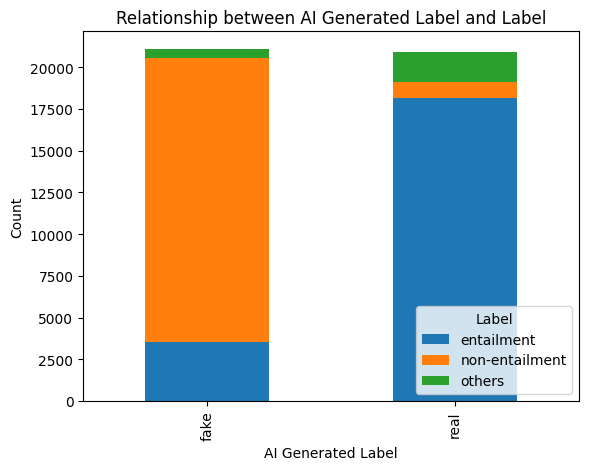

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a cross-tabulation
cross_tab = pd.crosstab(Final_Pre_GPT_Era_GPT_NLI_Dataset['ai_generated_label'], Final_Pre_GPT_Era_GPT_NLI_Dataset['Label'])

# Plot a stacked bar chart
cross_tab.plot(kind='bar', stacked=True)
plt.xlabel('AI Generated Label')
plt.ylabel('Count')
plt.title('Relationship between AI Generated Label and Label')
plt.show()


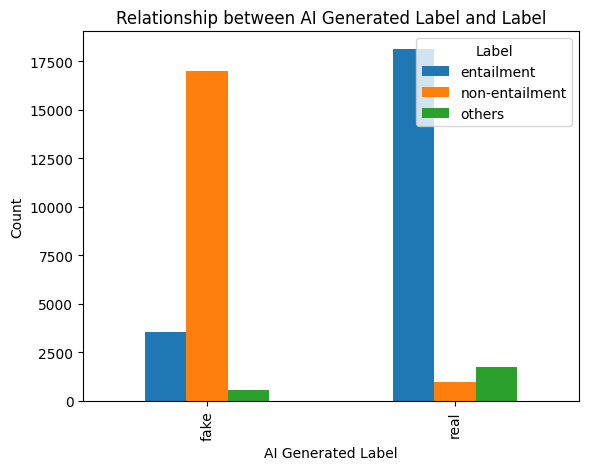

In [ ]:
cross_tab.plot(kind='bar', stacked=False)
plt.xlabel('AI Generated Label')
plt.ylabel('Count')
plt.title('Relationship between AI Generated Label and Label')
plt.show()


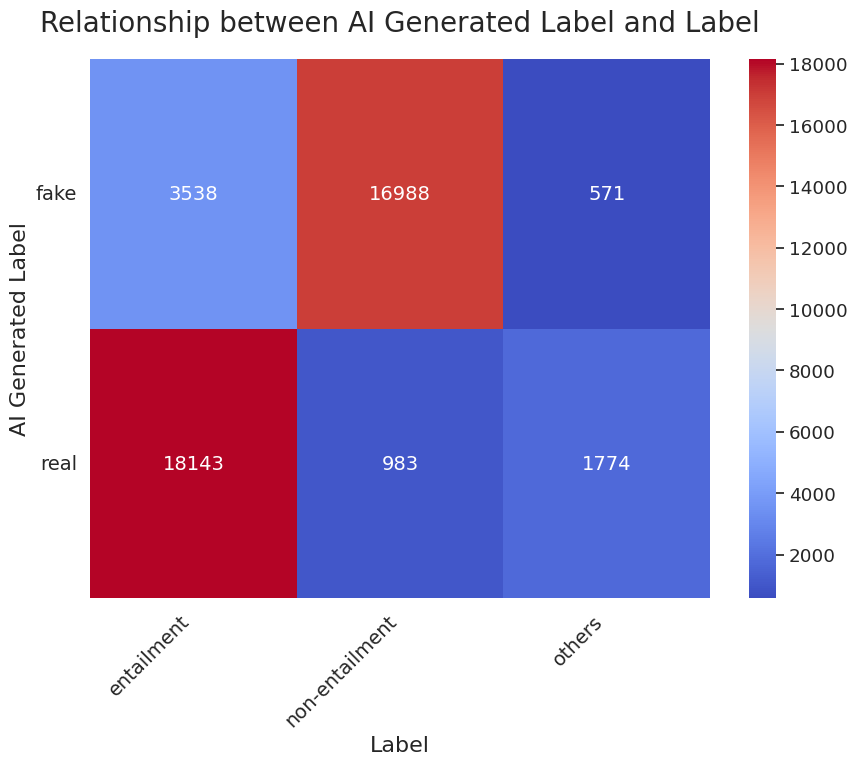

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,7))
sns.set(font_scale=1.2)  # Adjust to fit
heatmap = sns.heatmap(cross_tab, annot=True, fmt='d', cmap='coolwarm', annot_kws={"size": 14})

# Add a title and labels
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.title('Relationship between AI Generated Label and Label', size=20, pad=20)
plt.ylabel('AI Generated Label', size=16)
plt.xlabel('Label', size=16)

plt.show()



In [ ]:
# Save the DataFrame to a CSV file in the "entailment" folder
Final_Pre_GPT_Era_GPT_NLI_Dataset.to_csv("Final_Pre_GPT_Era_GPT_NLI_Dataset_Labels.csv", index=False)

## Consistency Analysis Implementation

### BLEURT-20 Scores

Requirements

In [ ]:
!pip install datasets
!pip install transformers
!pip install torch
!pip install bert_score
!pip install bleurt
!pip install sentencepiece
!pip install git+https://github.com/google-research/bleurt.git

Libraries

In [ ]:
#Download BLEURT-20 Model (Checkpoint)
!wget https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip
!unzip BLEURT-20.zip

In [ ]:
checkpoint = "BLEURT-20"
scorer = score.BleurtScorer(os.path.join(checkpoint))

In [ ]:
# Import libraries
import os
import pandas as pd
from tqdm import tqdm
from bleurt import score
import numpy as np
from bert_score import score as bert_score
from bleurt import score as bleurt_score

In [ ]:
%cd /gdrive/My Drive/F3/BLERT-20 Final Scores/ #REPLACE YOUR GOOGLE DRIVE DIRECTORY HERE
%ls

In [ ]:
PostGPT_Entailment = pd.read_csv("File_Name", encoding="UTF8")

In [ ]:
PostGPT_Entailment.info()

In [ ]:
!nvidia-smi

Mon Jun 12 11:17:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W /  70W |   4987MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Initialize a BLEURT scorer. You might need to download the checkpoint files and provide the correct path.
# scorer = score.BleurtScorer(os.path.join(checkpoint))

def bleurt_20_score(pair):
    human_written_content, aigenerated_content = pair
    results = scorer.score(references=[human_written_content], candidates=[aigenerated_content])
    return results[0]


# Make sure the temp directory exists
os.makedirs('temp', exist_ok=True)

# Split the DataFrame into chunks of 2 rows each
chunks = np.array_split(PostGPT_Entailment, len(PostGPT_Entailment) // 50 + 1)

for i, chunk in tqdm(enumerate(chunks), total=len(chunks)):
    # Apply the function to each chunk
    chunk['BLEURT-20'] = chunk.apply(lambda row: bleurt_20_score((row['human_written_content'], row['aigenerated_content'])), axis=1)

    # Save the processed chunk to a temporary CSV file
    chunk.to_csv(f'temp/chunk_{i}.csv', index=False)

# Concatenate all the temporary CSV files to create the final dataset
temp_files = [pd.read_csv(f'temp/chunk_{i}.csv') for i in tqdm(range(len(chunks)))]
final_dataset = pd.concat(temp_files)

# Save the final dataset
final_dataset.to_csv('PostGPT_Entailment_Blert.csv', index=False)

100%|██████████| 26/26 [00:00<00:00, 185.46it/s]


In [ ]:
final_dataset.info()

In [ ]:
# Save the final dataset
final_dataset.to_csv('Blert-20.csv', index=False)

### Bert Scores

Requirements

In [ ]:
!nvidia-smi

Mon Jun 12 11:23:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    28W /  70W |   5179MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd /gdrive/My Drive/F3/BERT Final Scores/ #REPLACE YOUR GOOGLE DRIVE DIRECTORY HERE
%ls

In [ ]:
df = pd.read_csv("File_Name", encoding="UTF8")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1275 entries, 0 to 48
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   human_written_content  1275 non-null   object 
 1   aigenerated_content    1275 non-null   object 
 2   model                  1275 non-null   object 
 3   num_completion_token   1275 non-null   int64  
 4   num_original_token     1275 non-null   int64  
 5   num_prompt_token       1275 non-null   int64  
 6   num_iagenerated_token  1275 non-null   int64  
 7   original_label         1275 non-null   bool   
 8   source_type            1275 non-null   object 
 9   ai_generated_label     1275 non-null   object 
 10  article_type           1275 non-null   object 
 11  pre_post_GPT           1275 non-null   object 
 12  dataset_source         1275 non-null   object 
 13  Prompt_type            1275 non-null   object 
 14  FLAN_entailment        1275 non-null   object 
 15  GPT_En

In [ ]:
df = final_dataset

In [ ]:
import pandas as pd
from bert_score import score
from tqdm import tqdm


candidates = df['aigenerated_content'].tolist()
references = df['human_written_content'].tolist()

# Initialize an empty list to store BERTScores
F1_list = []

batch_size = 100  # Adjust based on your system's memory

# Loop over candidate-reference pairs in batches
for i in tqdm(range(0, len(candidates), batch_size), desc="Computing BERTScore"):
    batch_candidates = candidates[i: i+batch_size]
    batch_references = references[i: i+batch_size]

    # Compute BERTScore for this batch
    _, _, F1 = score(batch_candidates, batch_references, lang='en', model_type='roberta-large', num_layers=24, idf=False, device='cuda')

    # Convert tensor to a list
    F1_list.extend(F1.tolist())

# Add a new column to your DataFrame
df['BERTScore'] = F1_list

# Save the final DataFrame
df.to_csv('Final_Pre_GPT_Era_GPT_BERTScore_Dataset_Labels.csv', index=False)


In [ ]:
df

,uuid,human_written_content,aigenerated_content,model,num_completion_token,num_original_token,num_prompt_token,num_iagenerated_token,original_label,source_type,ai_generated_label,article_type,pre_post_GPT,dataset_source,Prompt_type,GPT_Entailment_Explanation,GPT_NLI_Label,FLAN_NLI_Label,F1_scores
0,4ac69fef-1574-4a5e-8e85-dccdf2b56f69,"Blake Masters: ""Of course, I support Lindsey G...",🚨BREAKING🚨 Blake Masters just declared his sup...,gpt-3.5-turbo-0301,87,39,178,265,real,AI Machine,fake,twitter post,pre-GPT,x-Gen,minor,non-entailment. The premise states that Blake ...,non-entailment,entailment,0.955594
1,346688be-2b10-403d-a8ae-5fe9faed3214,“The Supreme Court has given us an opportunity...,BREAKING: Texas Governor announces new law to ...,gpt-3.5-turbo-0301,67,57,201,268,real,AI Machine,fake,twitter post,pre-GPT,x-Gen,minor,entailment,entailment,not-entailment,0.946922
2,aadc3fb7-1f74-41c5-9ebf-340483b589d2,Major fact check needed here. Biden says overt...,🚨 BREAKING NEWS 🚨\n\n😱 Biden caught spreading ...,gpt-3.5-turbo-0301,96,46,185,281,real,AI Machine,fake,twitter post,pre-GPT,x-Gen,minor,Non-entailment. The hypothesis contradicts the...,non-entailment,not-entailment,0.960543


## NLI Majority Vote: FLAN-T5 and GPT-3.5-Turbo

In [ ]:
%cd /gdrive/My Drive/F3/BLERT-20 Final Scores/ #REPLACE YOUR GOOGLE DRIVE DIRECTORY HERE
%ls

In [ ]:
Entailment = pd.read_csv("File_Name", encoding="UTF8")

In [ ]:
Entailment['GPT_NLI_Label'] = Entailment['GPT_NLI_Label'].replace("non-entailment", "not-entailment")

In [ ]:
Entailment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41997 entries, 0 to 41996
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   uuid                        41997 non-null  object
 1   human_written_content       41997 non-null  object
 2   aigenerated_content         41997 non-null  object
 3   model                       41997 non-null  object
 4   num_completion_token        41997 non-null  int64 
 5   num_original_token          41997 non-null  int64 
 6   num_prompt_token            41997 non-null  int64 
 7   num_iagenerated_token       41997 non-null  int64 
 8   original_label              41997 non-null  object
 9   source_type                 41997 non-null  object
 10  ai_generated_label          41997 non-null  object
 11  article_type                41997 non-null  object
 12  pre_post_GPT                41997 non-null  object
 13  dataset_source              41997 non-null  ob

In [ ]:
Entailment.GPT_NLI_Label.value_counts()

entailment        21681
not-entailment    17971
others             2345
Name: GPT_NLI_Label, dtype: int64

In [ ]:
Entailment.FLAN_NLI_Label.value_counts()

entailment                28169
not-entailment            13825
It's impossible to say        3
Name: FLAN_NLI_Label, dtype: int64

In [ ]:
# replacing the values
Entailment.loc[~Entailment['FLAN_NLI_Label'].isin(['entailment', 'not-entailment']), 'FLAN_NLI_Label'] = 'other'

print(Entailment)

                                       uuid  \
0      4ac69fef-1574-4a5e-8e85-dccdf2b56f69   
1      346688be-2b10-403d-a8ae-5fe9faed3214   
2      aadc3fb7-1f74-41c5-9ebf-340483b589d2   
3      8b95e37b-7396-4759-a828-1e128fa59471   
4      65c82312-0872-4b66-9249-2accfe1abb44   
...                                     ...   
41992  27c1c1eb-6274-4fef-8b37-31ccfb2c8cc7   
41993  2bfe0918-af5e-4c96-9955-d8f79d1edf0d   
41994  fbe8b77a-404a-452f-914b-f5d46fe3b048   
41995  be435832-62df-4311-8dae-f421648ef22c   
41996  7014dd07-3b74-4414-9459-c65106a3aff0   

                                   human_written_content  \
0      Blake Masters: "Of course, I support Lindsey G...   
1      “The Supreme Court has given us an opportunity...   
2      Major fact check needed here. Biden says overt...   
3      Thinking about the many times Justices Gorsuch...   
4      "There has never been a leak of a vote, much l...   
...                                                  ...   
41992  "What do

In [ ]:
%cd /gdrive/My Drive/F3/BLERT-20 Final Scores/ #REPLACE YOUR GOOGLE DRIVE DIRECTORY HERE
%ls

In [ ]:
BERTScore = pd.read_csv("BERTScore_Dataset_Labels.csv", encoding = 'UTF8')
BLEURT_20 = pd.read_csv("Final_BLEURT_20.csv", encoding = 'UTF8')

In [ ]:
BERTScore = BERTScore[['uuid','BERTScore']]

In [ ]:
BLEURT_20 =BLEURT_20[['uuid','BLEURT-20']]

In [ ]:
combined_df = Entailment.merge(BERTScore, on='uuid', how='outer')
combined_df = combined_df.merge(BLEURT_20, on='uuid', how='outer')

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41997 entries, 0 to 41996
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   uuid                        41997 non-null  object 
 1   human_written_content       41997 non-null  object 
 2   aigenerated_content         41997 non-null  object 
 3   model                       41997 non-null  object 
 4   num_completion_token        41997 non-null  int64  
 5   num_original_token          41997 non-null  int64  
 6   num_prompt_token            41997 non-null  int64  
 7   num_iagenerated_token       41997 non-null  int64  
 8   original_label              41997 non-null  object 
 9   source_type                 41997 non-null  object 
 10  ai_generated_label          41997 non-null  object 
 11  article_type                41997 non-null  object 
 12  pre_post_GPT                41997 non-null  object 
 13  dataset_source              419

In [ ]:
BLEURT_20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41997 entries, 0 to 41996
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   uuid       41997 non-null  object 
 1   BLEURT-20  41997 non-null  float64
dtypes: float64(1), object(1)
memory usage: 656.3+ KB


In [ ]:
import pandas as pd
import os
import glob

path = "/gdrive/My Drive/F3/BLERT-20 Final Scores/" #REPLACE YOUR GOOGLE DRIVE DIRECTORY HERE

# you can do it like this
combined_df.to_csv(f"{path}Entailment_Analysis.csv", index=False)

In [ ]:
Entailment = Entailment[Entailment['GPT_NLI_Label']!='others']

In [ ]:
Entailment = Entailment[Entailment['FLAN_NLI_Label'].isin(["entailment", "not-entailment"])]

In [ ]:
Entailment.head(1)

,uuid,human_written_content,aigenerated_content,model,num_completion_token,num_original_token,num_prompt_token,num_iagenerated_token,original_label,source_type,ai_generated_label,article_type,pre_post_GPT,dataset_source,Prompt_type,GPT_Entailment_Explanation,GPT_NLI_Label,FLAN_NLI_Label
0,4ac69fef-1574-4a5e-8e85-dccdf2b56f69,"Blake Masters: ""Of course, I support Lindsey G...",🚨BREAKING🚨 Blake Masters just declared his sup...,gpt-3.5-turbo-0301,87,39,178,265,real,AI Machine,fake,twitter post,pre-GPT,x-Gen,minor,non-entailment. The premise states that Blake ...,not-entailment,entailment


In [ ]:
Entailment.GPT_NLI_Label.value_counts()

entailment        21678
not-entailment    17971
Name: GPT_NLI_Label, dtype: int64

In [ ]:
Entailment.FLAN_NLI_Label.value_counts()

entailment        26193
not-entailment    13456
Name: FLAN_NLI_Label, dtype: int64

In [ ]:
Entailment.dataset_source.value_counts()

CoAID                      23878
FakeNewsNet_Gossipcop      12264
x-Gen                       3301
FakeNewsNet_Politifacts      206
Name: dataset_source, dtype: int64

In [ ]:
CoAID = Entailment[(Entailment['dataset_source']=='x-Gen') & (Entailment['article_type']=='twitter post')]


In [ ]:
CoAID = Entailment[(Entailment['dataset_source']=='FakeNewsNet_Politifacts') & (Entailment['article_type']=='news article')]

In [ ]:
CoAID.ai_generated_label.value_counts()

real    1652
fake    1649
Name: ai_generated_label, dtype: int64

In [ ]:
CoAID.ai_generated_label.value_counts()

fake    6831
real    5433
Name: ai_generated_label, dtype: int64

### Pre GPT

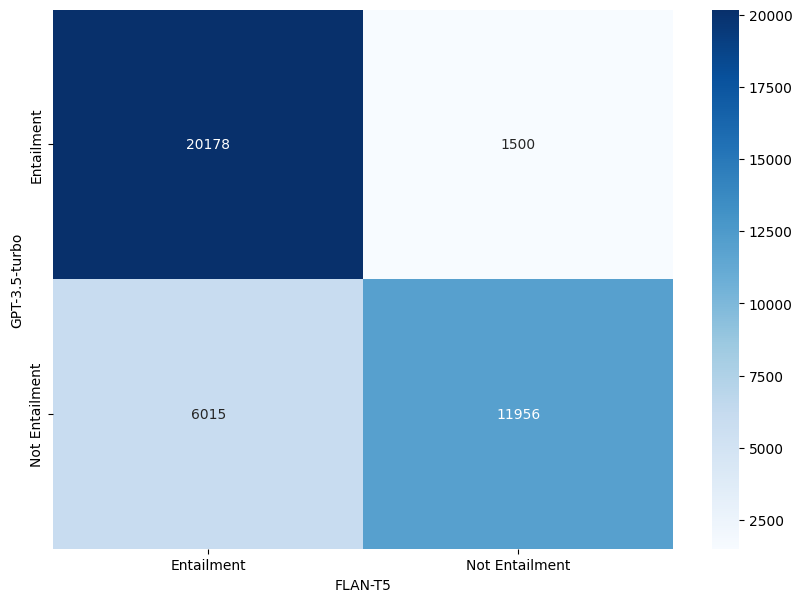

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# These are just example labels and predictions
true_labels = Entailment.GPT_NLI_Label
predictions = Entailment.FLAN_NLI_Label

# Create a confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Convert confusion matrix to DataFrame for easier plotting
cm_df = pd.DataFrame(cm, columns=['Entail', 'Not Entail'], index=['Entail', 'Not Entail'])

plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('FLAN-T5')
plt.ylabel('GPT-3.5-turbo')
plt.show()


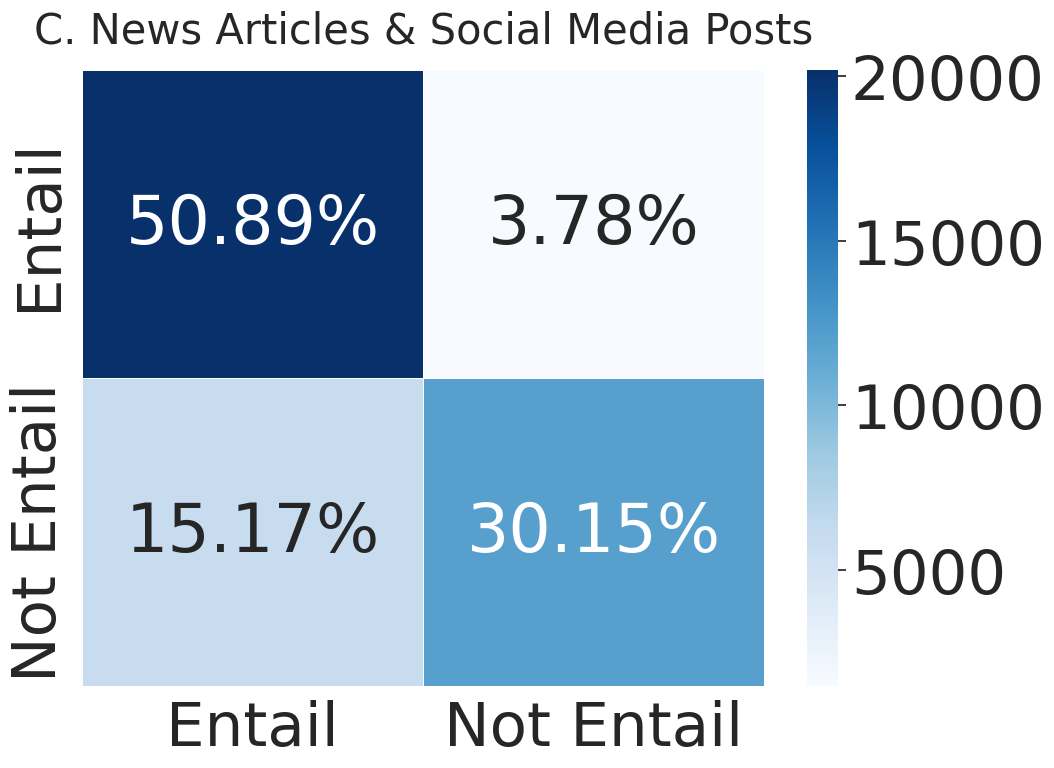

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# Set the font scale
sns.set(font_scale=4)  # Adjust this value to change the font size

# These are just example labels and predictions
true_labels = Entailment.GPT_NLI_Label
predictions = Entailment.FLAN_NLI_Label

# Create a confusion matrix
cf_matrix = confusion_matrix(true_labels, predictions)

# Define the labels
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = np.asarray(group_percentages).reshape(2,2)

# Convert confusion matrix to DataFrame for easier plotting
cm_df = pd.DataFrame(cf_matrix, columns=['Entail', 'Not Entail'], index=['Entail', 'Not Entail'])

# Plot the heatmap
plt.figure(figsize=(11,8))
sns.heatmap(cm_df, annot=labels, fmt='', cmap='Blues', linecolor='white', linewidths=0.5, cbar=True)
plt.title('C. News Articles & Social Media Posts', size=30, pad=20)
plt.show()


In [ ]:
Entailment.article_type.value_counts()

news article    28331
twitter post    11318
Name: article_type, dtype: int64

In [ ]:
Entailment_article = Entailment[Entailment['article_type'].isin(["news article"])]

In [ ]:
Entailment_post = Entailment[Entailment['article_type'].isin(["twitter post"])]

In [ ]:
Entailment_article.FLAN_NLI_Label.value_counts()

entailment        19428
not-entailment     8903
Name: FLAN_NLI_Label, dtype: int64

In [ ]:
Entailment_post.FLAN_NLI_Label.value_counts()

entailment        6765
not-entailment    4553
Name: FLAN_NLI_Label, dtype: int64

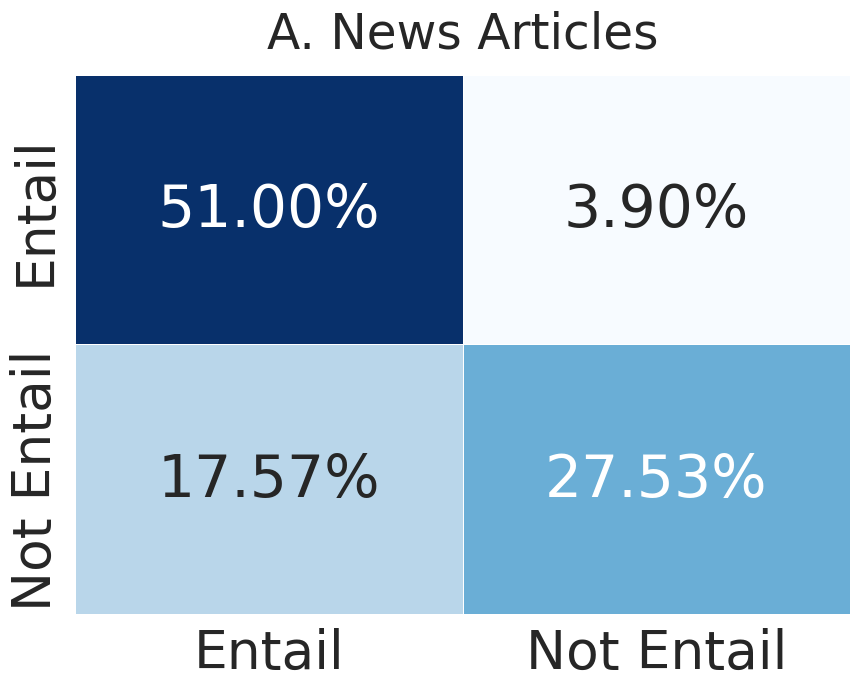

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# Set the font scale
sns.set(font_scale=3.5)  # Adjust this value to change the font size

# These are just example labels and predictions
true_labels = Entailment_article.GPT_NLI_Label
predictions = Entailment_article.FLAN_NLI_Label

# Create a confusion matrix
cf_matrix = confusion_matrix(true_labels, predictions)

# Define the labels
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = np.asarray(group_percentages).reshape(2,2)

# Convert confusion matrix to DataFrame for easier plotting
cm_df = pd.DataFrame(cf_matrix, columns=['Entail', 'Not Entail'], index=['Entail', 'Not Entail'])

# Plot the heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=labels, fmt='', cmap='Blues', linecolor='white', linewidths=0.5, cbar=False)
plt.title('A. News Articles', size=35, pad=20)
plt.show()


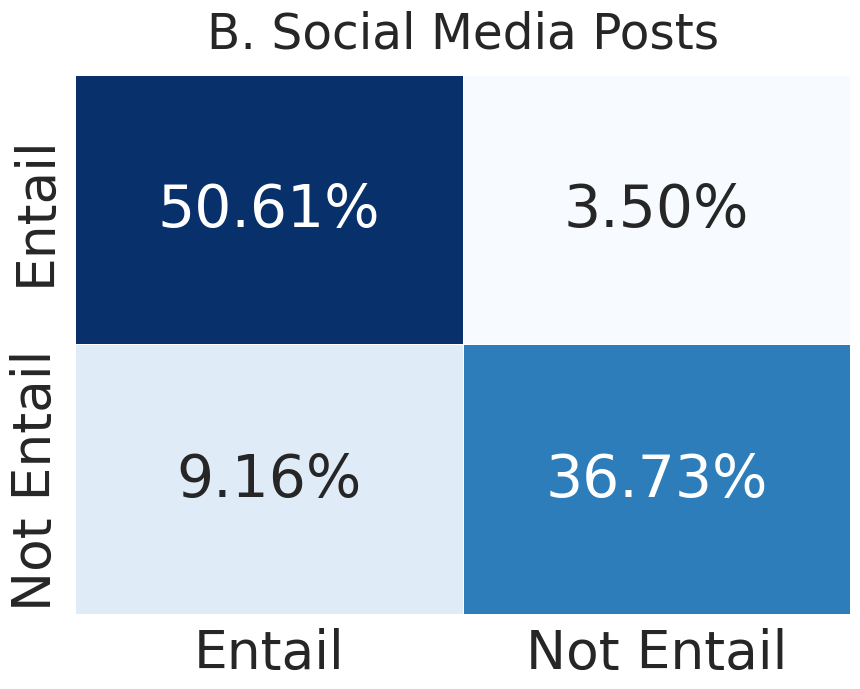

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# Set the font scale
sns.set(font_scale=3.5)  # Adjust this value to change the font size

# These are just example labels and predictions
true_labels = Entailment_post.GPT_NLI_Label
predictions = Entailment_post.FLAN_NLI_Label

# Create a confusion matrix
cf_matrix = confusion_matrix(true_labels, predictions)

# Define the labels
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = np.asarray(group_percentages).reshape(2,2)

# Convert confusion matrix to DataFrame for easier plotting
cm_df = pd.DataFrame(cf_matrix, columns=['Entail', 'Not Entail'], index=['Entail', 'Not Entail'])

# Plot the heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=labels, fmt='', cmap='Blues', linecolor='white', linewidths=0.5, cbar=False)
plt.title('B. Social Media Posts', size=35, pad=20)
plt.show()


In [ ]:
Entailment_article.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28331 entries, 3304 to 33974
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   uuid                        28331 non-null  object
 1   human_written_content       28331 non-null  object
 2   aigenerated_content         28331 non-null  object
 3   model                       28331 non-null  object
 4   num_completion_token        28331 non-null  int64 
 5   num_original_token          28331 non-null  int64 
 6   num_prompt_token            28331 non-null  int64 
 7   num_iagenerated_token       28331 non-null  int64 
 8   original_label              28331 non-null  object
 9   source_type                 28331 non-null  object
 10  ai_generated_label          28331 non-null  object
 11  article_type                28331 non-null  object
 12  pre_post_GPT                28331 non-null  object
 13  dataset_source              28331 non-null 

### Post-GPT

In [ ]:
PostGPT_EntailmentGPT = PostGPT_EntailmentGPT[PostGPT_EntailmentGPT['GPTEntailment_label'] != 'Other']
PostGPT_EntailmentGPT = PostGPT_EntailmentGPT[PostGPT_EntailmentGPT['FLAN_entailment'] != 'Other']

In [ ]:
PostGPT_EntailmentGPT_article = PostGPT_EntailmentGPT[PostGPT_EntailmentGPT['article_type'].isin(["news article"])]

In [ ]:
PostGPT_EntailmentGPT_post = PostGPT_EntailmentGPT[PostGPT_EntailmentGPT['article_type'].isin(["twitter post"])]

In [ ]:
PostGPT_EntailmentGPT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030 entries, 0 to 1274
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   human_written_content  1030 non-null   object
 1   aigenerated_content    1030 non-null   object
 2   model                  1030 non-null   object
 3   num_completion_token   1030 non-null   int64 
 4   num_original_token     1030 non-null   int64 
 5   num_prompt_token       1030 non-null   int64 
 6   num_iagenerated_token  1030 non-null   int64 
 7   original_label         1030 non-null   bool  
 8   source_type            1030 non-null   object
 9   ai_generated_label     1030 non-null   object
 10  article_type           1030 non-null   object
 11  pre_post_GPT           1030 non-null   object
 12  dataset_source         1030 non-null   object
 13  Prompt_type            1030 non-null   object
 14  FLAN_entailment        1030 non-null   object
 15  GPT_Entailment       

In [ ]:
PostGPT_EntailmentGPT.ai_generated_label.value_counts()

real    558
fake    472
Name: ai_generated_label, dtype: int64

In [ ]:
PostGPT_EntailmentGPT.Prompt_type.value_counts()

major       353
critical    341
minor       336
Name: Prompt_type, dtype: int64

In [ ]:
PostGPT_EntailmentGPT.article_type.value_counts()

twitter post    774
news article    256
Name: article_type, dtype: int64

In [ ]:
# Save the DataFrame to a CSV file in the "entailment" folder
PostGPT_EntailmentGPT.to_csv("PostGPT_Entailment_Done.csv", index=False)

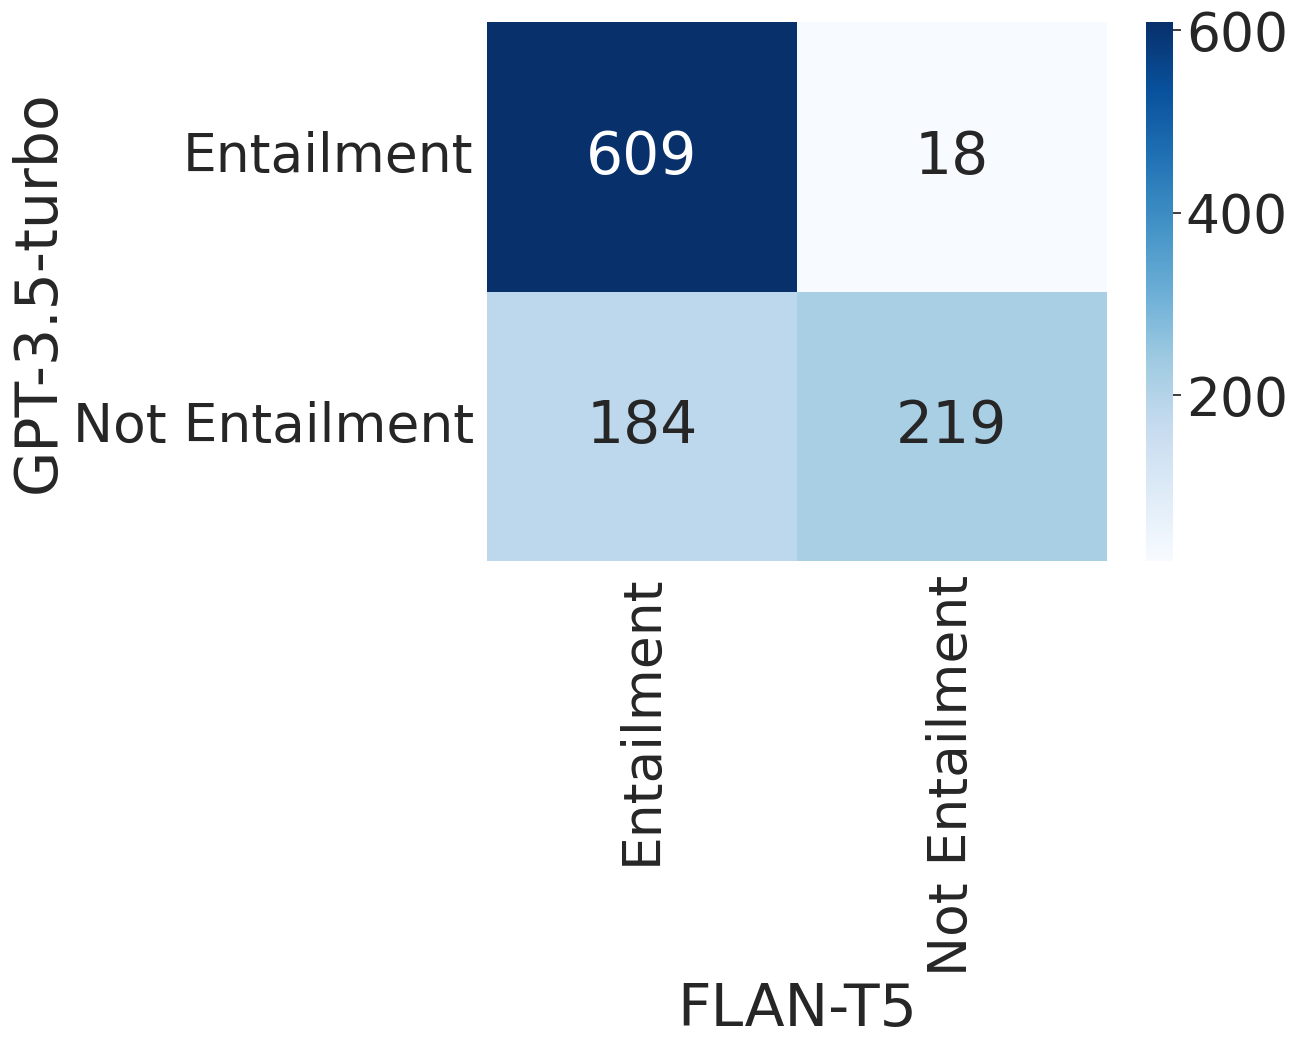

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# These are just example labels and predictions
true_labels = PostGPT_EntailmentGPT.GPTEntailment_label
predictions = PostGPT_EntailmentGPT.FLAN_entailment

# Create a confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Convert confusion matrix to DataFrame for easier plotting
cm_df = pd.DataFrame(cm, columns=['Entailment', 'Not Entailment'], index=['Entailment', 'Not Entailment'])

plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('FLAN-T5')
plt.ylabel('GPT-3.5-turbo')
plt.show()

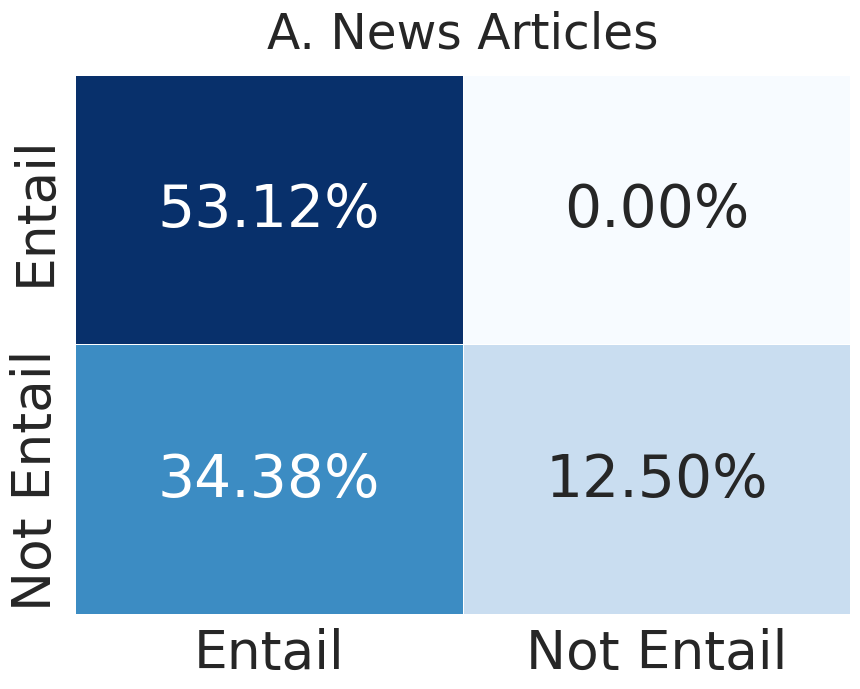

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# Set the font scale
sns.set(font_scale=3.5)  # Adjust this value to change the font size

# These are just example labels and predictions
true_labels = PostGPT_EntailmentGPT_article.GPTEntailment_label
predictions = PostGPT_EntailmentGPT_article.FLAN_entailment

# Create a confusion matrix
cf_matrix = confusion_matrix(true_labels, predictions)

# Define the labels
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = np.asarray(group_percentages).reshape(2,2)

# Convert confusion matrix to DataFrame for easier plotting
cm_df = pd.DataFrame(cf_matrix, columns=['Entail', 'Not Entail'], index=['Entail', 'Not Entail'])

# Plot the heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=labels, fmt='', cmap='Blues', linecolor='white', linewidths=0.5, cbar=False)
plt.title('A. News Articles', size=35, pad=20)
plt.show()


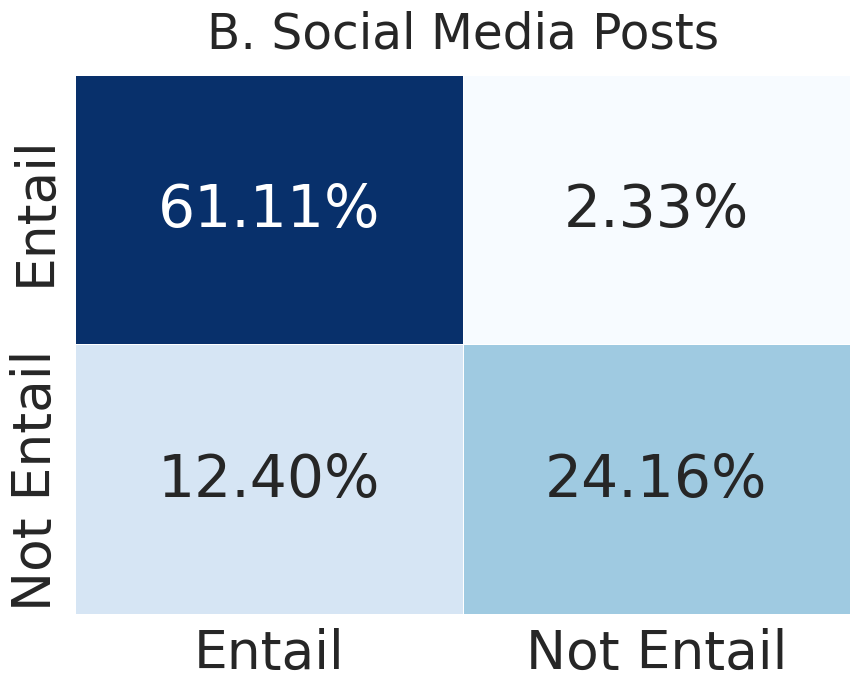

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# Set the font scale
sns.set(font_scale=3.5)  # Adjust this value to change the font size

# These are just example labels and predictions
true_labels = PostGPT_EntailmentGPT_post.GPTEntailment_label
predictions = PostGPT_EntailmentGPT_post.FLAN_entailment

# Create a confusion matrix
cf_matrix = confusion_matrix(true_labels, predictions)

# Define the labels
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = np.asarray(group_percentages).reshape(2,2)

# Convert confusion matrix to DataFrame for easier plotting
cm_df = pd.DataFrame(cf_matrix, columns=['Entail', 'Not Entail'], index=['Entail', 'Not Entail'])

# Plot the heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=labels, fmt='', cmap='Blues', linecolor='white', linewidths=0.5, cbar=False)
plt.title('B. Social Media Posts', size=35, pad=20)
plt.show()


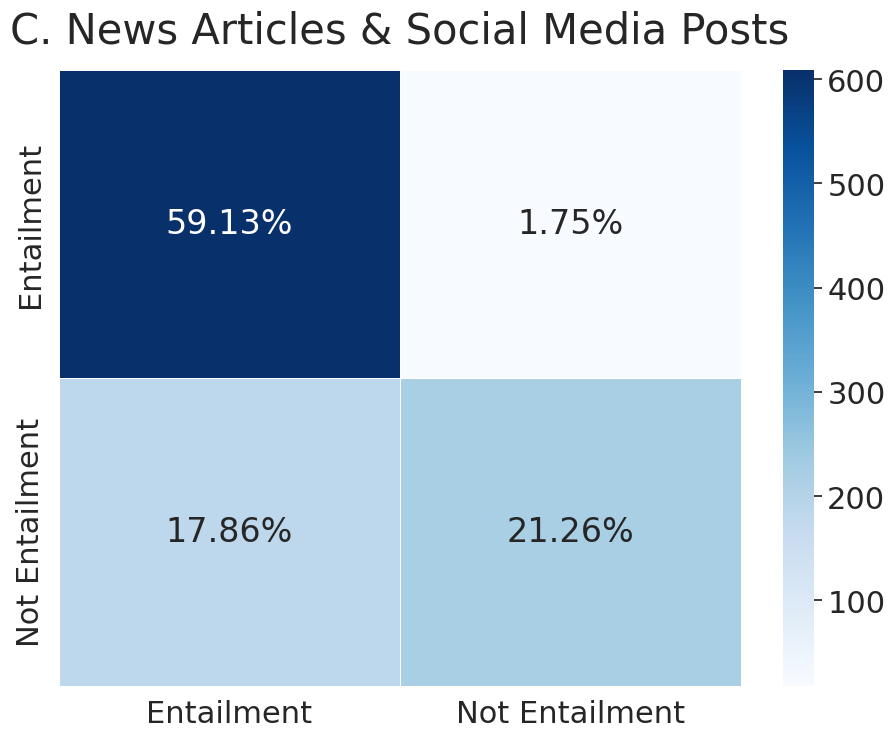

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# Set the font scale
sns.set(font_scale=2)  # Adjust this value to change the font size

# These are just example labels and predictions
true_labels = PostGPT_EntailmentGPT.GPTEntailment_label
predictions = PostGPT_EntailmentGPT.FLAN_entailment

# Create a confusion matrix
cf_matrix = confusion_matrix(true_labels, predictions)

# Define the labels
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = np.asarray(group_percentages).reshape(2,2)

# Convert confusion matrix to DataFrame for easier plotting
cm_df = pd.DataFrame(cf_matrix, columns=['Entailment', 'Not Entailment'], index=['Entailment', 'Not Entailment'])

# Plot the heatmap
plt.figure(figsize=(11,8))
sns.heatmap(cm_df, annot=labels, fmt='', cmap='Blues', linecolor='white', linewidths=0.5, cbar=True)
plt.title('C. News Articles & Social Media Posts', size=30, pad=20)
plt.show()


In [ ]:
# Use boolean indexing to select the desired rows
same_label_PostGPT_EntailmentGPT = PostGPT_EntailmentGPT[PostGPT_EntailmentGPT['GPTEntailment_label'] == PostGPT_EntailmentGPT['FLAN_entailment']]

In [ ]:
same_label_PostGPT_EntailmentGPT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 2 to 1274
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   human_written_content  828 non-null    object
 1   aigenerated_content    828 non-null    object
 2   model                  828 non-null    object
 3   num_completion_token   828 non-null    int64 
 4   num_original_token     828 non-null    int64 
 5   num_prompt_token       828 non-null    int64 
 6   num_iagenerated_token  828 non-null    int64 
 7   original_label         828 non-null    bool  
 8   source_type            828 non-null    object
 9   ai_generated_label     828 non-null    object
 10  article_type           828 non-null    object
 11  pre_post_GPT           828 non-null    object
 12  dataset_source         828 non-null    object
 13  Prompt_type            828 non-null    object
 14  FLAN_entailment        828 non-null    object
 15  GPT_Entailment        

In [ ]:
same_label_PostGPT_EntailmentGPT.ai_generated_label.value_counts()

real    546
fake    282
Name: ai_generated_label, dtype: int64

In [ ]:
same_label_PostGPT_EntailmentGPT.article_type.value_counts()

twitter post    660
news article    168
Name: article_type, dtype: int64

In [ ]:
PostGPT_EntailmentGPT.article_type.value_counts()

twitter post    774
news article    256
Name: article_type, dtype: int64

In [ ]:
Post_PostGPT_EntailmentGPT =  same_label_PostGPT_EntailmentGPT[same_label_PostGPT_EntailmentGPT['article_type'] == 'twitter post']

In [ ]:
Post_PostGPT_EntailmentGPT.ai_generated_label.value_counts()

real    418
fake    242
Name: ai_generated_label, dtype: int64

In [ ]:
Article_PostGPT_EntailmentGPT =  same_label_PostGPT_EntailmentGPT[same_label_PostGPT_EntailmentGPT['article_type'] == 'news article']

In [ ]:
Article_PostGPT_EntailmentGPT.ai_generated_label.value_counts()

real    128
fake     40
Name: ai_generated_label, dtype: int64

# Pre-GPT3.5-Turbo Data: Train-Test Splits

We use the train_test_split function from sklearn to divide our data. This ensures that our models get a fair evaluation on unseen data. We split preGPT-3.5 data into training (70%), vali-dation (20%), and test (10%) sets using stratified random sampling for a balanced class representa-
tion.

In [ ]:
# import necessary libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [ ]:
%cd /gdrive/My Drive/F3/# Change this path to your google Drive directory
%ls

## AI-Generated Text

### Articles

In [ ]:
# load Prompt_Min_Article dataset

X = Prompt_Min_Article.aigenerated_content
y = Prompt_Min_Article.ai_generated_label

# First split into 70% train, 30% temporary split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y, random_state=1)

# Second split the 30% temp into 20% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=1)


# Create the folder if it doesn't exist
if not os.path.exists("Prompt_Min_Article"):
    os.makedirs("Prompt_Min_Article")

# Save the DataFrame to a CSV file in the "entailment" folder
X_train.to_csv("Prompt_Min_Article/X_train_Prompt_Min_Article.csv", index=False)
X_test.to_csv("Prompt_Min_Article/X_test_Prompt_Min_Article.csv", index=False)
X_val.to_csv("Prompt_Min_Article/X_val_Prompt_Min_Article.csv", index=False)
y_train.to_csv("Prompt_Min_Article/y_train_Prompt_Min_Article.csv", index=False)
y_test.to_csv("Prompt_Min_Article/y_test_Prompt_Min_Article.csv", index=False)
y_val.to_csv("Prompt_Min_Article/y_val_Prompt_Min_Article.csv", index=False)


In [ ]:
# load Prompt_Maj_Article dataset

X = Prompt_Maj_Article.aigenerated_content
y = Prompt_Maj_Article.ai_generated_label

# First split into 70% train, 30% temporary split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y, random_state=1)

# Second split the 30% temp into 20% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=1)


# Create the folder if it doesn't exist
if not os.path.exists("Prompt_Maj_Article"):
    os.makedirs("Prompt_Maj_Article")

# Save the DataFrame to a CSV file in the "entailment" folder
X_train.to_csv("Prompt_Maj_Article/X_train_Prompt_Maj_Article.csv", index=False)
X_test.to_csv("Prompt_Maj_Article/X_test_Prompt_Maj_Article.csv", index=False)
X_val.to_csv("Prompt_Maj_Article/X_val_Prompt_Maj_Article.csv", index=False)
y_train.to_csv("Prompt_Maj_Article/y_train_Prompt_Maj_Article.csv", index=False)
y_test.to_csv("Prompt_Maj_Article/y_test_Prompt_Maj_Article.csv", index=False)
y_val.to_csv("Prompt_Maj_Article/y_val_Prompt_Maj_Article.csv", index=False)


In [ ]:
# load Prompt_Crit_Article dataset

X = Prompt_Crit_Article.aigenerated_content
y = Prompt_Crit_Article.ai_generated_label

# First split into 70% train, 30% temporary split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y, random_state=1)

# Second split the 30% temp into 20% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=1)

# Create the folder if it doesn't exist
if not os.path.exists("Prompt_Crit_Article"):
    os.makedirs("Prompt_Crit_Article")

# Save the DataFrame to a CSV file in the "entailment" folder
X_train.to_csv("Prompt_Crit_Article/X_train_Prompt_Crit_Article.csv", index=False)
X_test.to_csv("Prompt_Crit_Article/X_test_Prompt_Crit_Article.csv", index=False)
X_val.to_csv("Prompt_Crit_Article/X_val_Prompt_Crit_Article.csv", index=False)
y_train.to_csv("Prompt_Crit_Article/y_train_Prompt_Crit_Article.csv", index=False)
y_test.to_csv("Prompt_Crit_Article/y_test_Prompt_Crit_Article.csv", index=False)
y_val.to_csv("Prompt_Crit_Article/y_val_Prompt_Crit_Article.csv", index=False)


### Posts

In [ ]:
# load Prompt_Min_Article dataset

X = Prompt_Min_Post.aigenerated_content
y = Prompt_Min_Post.ai_generated_label

# First split into 70% train, 30% temporary split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y, random_state=1)

# Second split the 30% temp into 20% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=1)


# Create the folder if it doesn't exist
if not os.path.exists("Prompt_Min_Post"):
    os.makedirs("Prompt_Min_Post")

# Save the DataFrame to a CSV file in the "entailment" folder
X_train.to_csv("Prompt_Min_Post/X_train_Prompt_Min_Post.csv", index=False)
X_test.to_csv("Prompt_Min_Post/X_test_Prompt_Min_Post.csv", index=False)
X_val.to_csv("Prompt_Min_Post/X_val_Prompt_Min_Post.csv", index=False)
y_train.to_csv("Prompt_Min_Post/y_train_Prompt_Min_Post.csv", index=False)
y_test.to_csv("Prompt_Min_Post/y_test_Prompt_Min_Post.csv", index=False)
y_val.to_csv("Prompt_Min_Post/y_val_Prompt_Min_Post.csv", index=False)


In [ ]:
# load Prompt_Min_Article dataset

X = Prompt_Maj_Post.aigenerated_content
y = Prompt_Maj_Post.ai_generated_label

# First split into 70% train, 30% temporary split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y, random_state=1)

# Second split the 30% temp into 20% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=1)


# Create the folder if it doesn't exist
if not os.path.exists("Prompt_Maj_Post"):
    os.makedirs("Prompt_Maj_Post")

# Save the DataFrame to a CSV file in the "entailment" folder
X_train.to_csv("Prompt_Maj_Post/X_train_Prompt_Maj_Post.csv", index=False)
X_test.to_csv("Prompt_Maj_Post/X_test_Prompt_Maj_Post.csv", index=False)
X_val.to_csv("Prompt_Maj_Post/X_val_Prompt_Maj_Post.csv", index=False)
y_train.to_csv("Prompt_Maj_Post/y_train_Prompt_Maj_Post.csv", index=False)
y_test.to_csv("Prompt_Maj_Post/y_test_Prompt_Maj_Post.csv", index=False)
y_val.to_csv("Prompt_Maj_Post/y_val_Prompt_Maj_Post.csv", index=False)


In [ ]:
# load Prompt_Min_Article dataset

X = Prompt_Crit_Post.aigenerated_content
y = Prompt_Crit_Post.ai_generated_label

# First split into 70% train, 30% temporary split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y, random_state=1)

# Second split the 30% temp into 20% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=1)


# Create the folder if it doesn't exist
if not os.path.exists("Prompt_Crit_Post"):
    os.makedirs("Prompt_Crit_Post")

# Save the DataFrame to a CSV file in the "entailment" folder
X_train.to_csv("Prompt_Crit_Post/X_train_Prompt_Crit_Post.csv", index=False)
X_test.to_csv("Prompt_Crit_Post/X_test_Prompt_Crit_Post.csv", index=False)
X_val.to_csv("Prompt_Crit_Post/X_val_Prompt_Crit_Post.csv", index=False)
y_train.to_csv("Prompt_Crit_Post/y_train_Prompt_Crit_Post.csv", index=False)
y_test.to_csv("Prompt_Crit_Post/y_test_Prompt_Crit_Post.csv", index=False)
y_val.to_csv("Prompt_Crit_Post/y_val_Prompt_Crit_Post.csv", index=False)


## Human-Written

### Articles

In [ ]:
# load Prompt_Maj_Article dataset

X = Human_Article.content
y = Human_Article.label

# First split into 70% train, 30% temporary split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y, random_state=1)

# Second split the 30% temp into 20% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=1)


# Create the folder if it doesn't exist
if not os.path.exists("Human_Article"):
    os.makedirs("Human_Article")

# Save the DataFrame to a CSV file in the "entailment" folder
X_train.to_csv("Human_Article/X_train_Human_Article.csv", index=False)
X_test.to_csv("Human_Article/X_test_Human_Article.csv", index=False)
X_val.to_csv("Human_Article/X_val_Human_Article.csv", index=False)
y_train.to_csv("Human_Article/y_train_Human_Article.csv", index=False)
y_test.to_csv("Human_Article/y_test_Human_Article.csv", index=False)
y_val.to_csv("Human_Article/y_val_Human_Article.csv", index=False)


### Post

In [ ]:
# load Prompt_Maj_Post dataset

X = Human_Post.content
y = Human_Post.label

# First split into 70% train, 30% temporary split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y, random_state=1)

# Second split the 30% temp into 20% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=1)

# Create the folder if it doesn't exist
if not os.path.exists("Human_Post"):
    os.makedirs("Human_Post")

# Save the DataFrame to a CSV file in the "entailment" folder
X_train.to_csv("Human_Post/X_train_Human_Post.csv", index=False)
X_test.to_csv("Human_Post/X_test_Human_Post.csv", index=False)
X_val.to_csv("Human_Post/X_val_Human_Post.csv", index=False)
y_train.to_csv("Human_Post/y_train_Human_Post.csv", index=False)
y_test.to_csv("Human_Post/y_test_Human_Post.csv", index=False)
y_val.to_csv("Human_Post/y_val_Human_Post.csv", index=False)


## Classification Prompt Engineering

### Cloze Prompt Template

In [ ]:
"""
VaN: Vanillla Cloze prompt
Con: Vanilla Cloze prompt with a sense of condifence and Justification
CoT: Vanilla Cloze prompt with Automatic Chain of Thought
MSReN: Vanilla Cloze prompt with manual Chain of Thought
MSReN_CoT: Vanilla Cloze prompt with combined sense of confidence, Justification and Chain of Thought
DeF_Gen: Vanilla Cloze with defination reasoning
DeF_SpeC: Vanilla Cloze with defination reasoning with more details
"""
def get_prompt(prompt_type):

  # Default assignment
  role = ""
  prompt = ""
  verbalizer = ""

  if prompt_type == "VaN":
    role = "You are an AI news detector assistant, your task is to determine the authenticity of real or fake news."
    prompt = "The answer should be exact 'True' or 'False'."
    verbalizer = "Analyze the given text and make a sound judgement regarding its authenticity. "

  elif prompt_type == "Con":
    role = "You are an AI news detector assistant, your role is to analyze and classify the given text as real or fake news based on your confidence."
    verbalizer = "Analyze the given text and determine if the text is real, label it as 'True', and if it is fake, label it as 'False'. Think about justifications for you answer and you confidence with your answer with a score between 0 and 100. Make a decision based on your justification and confidence score."
    prompt = "The answer should be exact 'True' or 'False'."

  elif prompt_type == "CoT":
    role = "You are an AI news detector assistant, your role is to analyze and classify the given text as real or fake news."
    prompt = "The answer should be exact 'True' or 'False'."
    verbalizer = "Analyze the given text and make a sound judgement regarding its authenticity. Let’s think about your answer step by step, then make a final decision on your answer."


  elif prompt_type =="MSReN":
    role = "You are an AI fact checker assistant, your role is to analyze and classify the given text as real or fake news."
    prompt =  """ Let's think step by step as a fact-checker to classify if a given text is fake or real.
                - First, make a judgement and think about your answer. If the answer is 'real', return 'True' indicating that the text is real news. If your is 'False', move on to the next step.

                - Next, as a fact-checker, you should analyze the given text carefully to see if there are any indicators that it might be fake. Look for things like misleading information, false claims, or biased language, and if you find any such indicators, return 'False' indicating that the text is fake. If you do not find any such indicators, go to the next step.

                - Finally, as a fact-checker, if you still cannot classify the text as fake, return 'True' indicating that the text is not fake. This may be the case if the text appears to be objective and factually accurate, and there are no clear indicators of misinformation or propaganda.

                - Remember to think step by step as a fact-checker and anslyze why each step is necessary to reach the correct result.

                 Your final answer should be exact 'True' or 'False'."""
    verbalizer = "Analyze the given text and make a sound judgement regarding its authenticity."

  elif prompt_type == "MSReN_CoT":
    role = "You are an AI fact checker assistant, your role is to analyze and classify the given text as real or fake news."
    prompt = """  Let's think step by step as a fact-checker to classify if a given text is fake or real

                - First, make a judgement and think about your answer. If the label is 'real', return 'True'. If the label is 'False', move on to the next step.

                - Next, Think about your confidence with your answer with a score between 0 and 100. If the confidence score is above 90 , then Returnn 'False'. Otherwise, move on to the next step.

                - Finally, Think about justification for you answer. If the justification provides evidence that the text is fake, then then Return 'False'. If the justification provides no evidence that the text is fake, then return 'False'.

                - Think about about your answer step by step, then make a final decision.
                Your answer should be exact 'True' or 'False'."""
    verbalizer = "Analyze the given text and make a sound judgement regarding its authenticity."

  elif prompt_type == "DeF_Gen":
    role = "You are an AI langauge model trained to classify news from articles and social media postas as fake or real new."
    prompt = "Determine the veracity of the following news article based on its content, tone, language, and sources. If it contains factual information that is verifiable and supported by evidence, it is 'True'. If it contains misleading, inaccurate, or fabricated information that is intended to deceive readers, it is 'False'. Your final answer should be exact 'True' or 'False'."
    verbalizer = "Analyze the given text and make a sound judgement regarding its authenticity. "

  elif prompt_type == "DeF_SpeC":
    role = "You are an AI langauge model trained to classify news articles and social media postas fake or real."
    prompt = """
            Classify if a given text is fake or not using the following JSON format. You are given a news articles and are tasked with classifying them as either "True" or "False". Using the content of each article, determine whether it is real or fake and assign it a label accordingly. Real articles should contain factual information that is verifiable and supported by evidence. Fake articles should contain misleading, inaccurate, or fabricated information that is intended to deceive readers.

            Remember to consider the tone, language, and sources used in each article when making your classification. "Your final answer should be exact 'True' or 'False'.
            """
    verbalizer = "Classify this article or social media post as real or fake:"

  complete_prompt = f"{role} {prompt} {verbalizer}"
  return complete_prompt

# Generative AI Classification

### GPT-3.5-Turbo Classification

In [ ]:
!pip install pandarallel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import openai
import os
import multiprocessing
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [ ]:
# Set up the OpenAI API
import json

def ai_text_classification(prompt, content):
  # Create a new API client for each call
  api_key = "xx-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx" # API key
  openai.api_key = api_key
  prompt = get_prompt(prompt_type)


  while True:
        try:

          time.sleep(0.6)  # Sleep for 600 milliseconds
          response = openai.ChatCompletion.create(
              model="gpt-3.5-turbo",
              temperature=0.7,
              messages=[
                  {"role": "system", "content": prompt},
                  {"role": "user", "content": content},
              ],
          )

          # Get the prediction
          return response.choices[0].message.content
          break
        except Exception as e:
          print(e)
          time.sleep(60)  # Wait for 60 seconds before retrying




In [ ]:
%cd /gdrive/My Drive/F3 #REPLACE YOUR GOOGLE DRIVE DIRECTORY HERE
%ls

In [ ]:
X_test = pd.read_csv("X_test_Prompt_Min_Post.csv", encoding= "UTF8")
y_test = pd.read_csv("y_test_Prompt_Min_Post.csv", encoding= "UTF8")
X_test = X_test.rename(columns={'content':'aigenerated_content'})
y_test = y_test.rename(columns={'label':'ai_generated_label'})
# y_test = y_test['ai_generated_label'].replace({'real':True, 'fake':False})

In [ ]:
df2 = X_test

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   aigenerated_content  335 non-null    object
dtypes: object(1)
memory usage: 2.7+ KB


In [ ]:
df2.head(2)

,aigenerated_content
0,"""OMG! @claudiahammond just confirmed that the ..."
1,🚨💥BREAKING NEWS💥🚨\nObama recorded on hot micro...


In [ ]:
fake_articles_results_folder = 'Human_Classification'
os.makedirs(fake_articles_results_folder, exist_ok=True)
P2 = pd.read_csv("XGEN_PostGPT_Post.csv", encoding= 'UTF8')

In [ ]:
import pandas as pd

In [ ]:
A = pd.read_csv("PostGPT_Article_.csv", encoding= 'UTF8')
P = pd.read_csv("PostGPT_Post_.csv", encoding= 'UTF8')
P2 = pd.read_csv("XGEN_PostGPT_Post.csv", encoding= 'UTF8')

In [ ]:
P2 = P2[['human_written_content','original_label','article_type','source_type','pre_post_GPT', 'dataset_source']]
P2.rename(columns={'human_written_content':'content', 'original_label':'label'}, inplace=True)
df2 = pd.concat([A, P, P2])

<ipython-input-22-5b76b9827d74>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P2.rename(columns={'human_written_content':'content', 'original_label':'label'}, inplace=True)


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2612 entries, 0 to 59
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   article_id      330 non-null    object 
 1   content         2612 non-null   object 
 2   label           2612 non-null   object 
 3   text_length     2552 non-null   float64
 4   date            2552 non-null   object 
 5   article_type    2612 non-null   object 
 6   source_type     2612 non-null   object 
 7   pre_post_GPT    2612 non-null   object 
 8   dataset_source  2612 non-null   object 
 9   claim           2222 non-null   object 
dtypes: float64(1), object(9)
memory usage: 224.5+ KB


In [ ]:
df2['label'] = df2['label'].replace({'real': True, 'fake': False})
df2['label'] = df2['label'].replace({'TRUE': True, 'FALSE': False})

In [ ]:
df2.label.value_counts()

False    1736
True      876
Name: label, dtype: int64

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2612 entries, 0 to 59
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   article_id      330 non-null    object 
 1   content         2612 non-null   object 
 2   label           2612 non-null   bool   
 3   text_length     2552 non-null   float64
 4   date            2552 non-null   object 
 5   article_type    2612 non-null   object 
 6   source_type     2612 non-null   object 
 7   pre_post_GPT    2612 non-null   object 
 8   dataset_source  2612 non-null   object 
 9   claim           2222 non-null   object 
dtypes: bool(1), float64(1), object(8)
memory usage: 206.6+ KB


In [ ]:
def normalize_pred_veracity(output):
  if "true." in str(output).lower():
      answer = True
  elif 'false.' in str(output).lower():
      answer = False
  else:
      answer = None
  return answer


In [ ]:
import pandas as pd
from pandarallel import pandarallel
from tqdm import tqdm
import os

# Make sure the temp directory exists
os.makedirs('temp_human_OOD', exist_ok=True)

# Initialize pandarallel
pandarallel.initialize()

def process_row(row, prompt_type):
    # Here goes your logic to process each row
    content = row['content']
    output_original = ai_text_classification(prompt_type, content)
    return {
            'human_written_content':row['content'],
            'label':row['label'],
            'article_type':row['article_type'],
            'source_type':row['source_type'],
            'pre_post_GPT':row['pre_post_GPT'],
            'dataset_source':row['dataset_source'],
            'GPT_Label': normalize_pred_veracity(output_original),
            'GPT_Class_Explanation': output_original,
            'Prompt': prompt_type

        }

# Set the prompt pattern
prompt_types = [
    "VaN",
    "Con",
    "CoT",
    "MSReN",
    "MSReN_CoT",
    "DeF_Gen",
    "DeF_SpeC"
]

full_df = pd.DataFrame()

for prompt_type in tqdm(prompt_types):
    print(prompt_type)

    # split dataframe into chunks of 50 rows
    chunks = [df2[i:i+50] for i in range(0, df2.shape[0], 50)]


    # Find the index of the chunk where processing stopped
    start_index = next((i for i, chunk in enumerate(chunks) if f'Prompt_{prompt_type}_{i+1}.csv' == 'Prompt_DeF_Gen_34.csv'), 0)

    for i, chunk in tqdm(enumerate(chunks[start_index:]), total=len(chunks[start_index:])):
        i += start_index # correct the index number
        chunk_copy = chunk.copy()
        chunk_copy[f'results_{prompt_type}'] = chunk_copy.parallel_apply(lambda row: process_row(row, prompt_type), axis=1)
        chunk_results_df = pd.DataFrame(chunk_copy[f'results_{prompt_type}'].tolist())
        chunk_results_df.to_csv(f'temp_human_OOD/Prompt_{prompt_type}_{i+1}.csv', index=False)

        # Append chunk results to full_df
        full_df = full_df.append(chunk_results_df, ignore_index=True)

full_df.to_csv('Huamn_GPT_OOD.csv', index=False)


In [ ]:
import pandas as pd
import os
import glob

path = "/gdrive/My Drive/F3" #REPLACE YOUR GOOGLE DRIVE DIRECTORY HERE

# Use glob to match the pattern ‘csv’
all_files = glob.glob(os.path.join(path, "Prompt*.csv"))

# Use a list comprehension to process all csv files in the specified directory
df_from_each_file = (pd.read_csv(f) for f in all_files)

# Concatenate all data into one DataFrame
full_df = pd.concat(df_from_each_file, ignore_index=True)

In [ ]:
full_df.to_csv('Human_GPTClassification.csv', index=False)

In [ ]:
%ls

ls: cannot access 'drive': Transport endpoint is not connected
drive/  Human_GPTClassification.csv  sample_data/


In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18284 entries, 0 to 18283
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   human_written_content  18284 non-null  object
 1   label                  18284 non-null  bool  
 2   article_type           18284 non-null  object
 3   source_type            18284 non-null  object
 4   pre_post_GPT           18284 non-null  object
 5   dataset_source         18284 non-null  object
 6   GPT_Label              14698 non-null  object
 7   GPT_Class_Explanation  18284 non-null  object
 8   Prompt                 18284 non-null  object
dtypes: bool(1), object(8)
memory usage: 1.1+ MB


In [ ]:
X_test = pd.concat([full_df,y_test], axis=1)

In [ ]:
X_test = X_test.dropna()

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 3 to 334
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   human_written_content  96 non-null     object
 1   GPT_Label              96 non-null     object
 2   GPT_Explanation        96 non-null     object
 3   ai_generated_label     96 non-null     object
dtypes: object(4)
memory usage: 3.8+ KB


In [ ]:
print(X_test.columns)

Index(['human_written_content', 'GPT_Label', 'GPT_Explanation',
       'ai_generated_label'],
      dtype='object')


In [ ]:
X_test.GPT_Label.value_counts()

False    71
True     25
Name: GPT_Label, dtype: int64

In [ ]:
y_test.ai_generated_label.value_counts()

real    181
fake    154
Name: ai_generated_label, dtype: int64

In [ ]:
X_test["GPT_label"] = X_test["GPT_Label"].astype(bool)
X_test.GPT_Label.value_counts()

False    71
True     25
Name: GPT_Label, dtype: int64

In [ ]:
# Encode labels in column 'GPT_Van_Label'.
le = LabelEncoder()
X_test['GPT_Van_Label_encoded'] = le.fit_transform(X_test['GPT_label'])

# Convert the encoded labels to boolean
X_test['GPT_Van_Label_encoded'] = X_test['GPT_Van_Label_encoded'].astype(bool)

# Now use 'GPT_Van_Label_encoded' for classification report
y_true = X_test['ai_generated_label']
y_pred = X_test['GPT_Van_Label_encoded']
y_true = y_true.replace({'real': True, 'fake': False})
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.62      0.98      0.76        45
        True       0.96      0.47      0.63        51

    accuracy                           0.71        96
   macro avg       0.79      0.72      0.70        96
weighted avg       0.80      0.71      0.69        96



### FLAN-T5 Classification

In [ ]:
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [ ]:
%cd /gdrive/My Drive/F3 #REPLACE YOUR GOOGLE DRIVE DIRECTORY HERE
%ls

/gdrive/.shortcut-targets-by-id/1-q8PQLnrlI1K9omfwKeaKGhV2ToETrvd/Xgen/FakeNewsDetection/DevData/Ai-Gen - Completed Data/Experiment Data/Full_Dataset/4. Data Splits/PostGPT_Era/Human
PostGPT_Article_.csv  PostGPT_Post_.csv  XGEN_PostGPT_Post.csv


In [ ]:
A = pd.read_csv("PostGPT_Article_.csv", encoding= 'UTF8')

In [ ]:
P = pd.read_csv("PostGPT_Post_.csv", encoding= 'UTF8')

In [ ]:
P2 = pd.read_csv("XGEN_PostGPT_Post.csv", encoding= 'UTF8')

In [ ]:
P2 = P2[['human_written_content','original_label','article_type','source_type','pre_post_GPT', 'dataset_source']]

In [ ]:
P2.rename(columns={'human_written_content':'content', 'original_label':'label'}, inplace=True)

In [ ]:
A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   article_id      330 non-null    object
 1   content         330 non-null    object
 2   label           330 non-null    bool  
 3   text_length     330 non-null    int64 
 4   date            330 non-null    object
 5   article_type    330 non-null    object
 6   source_type     330 non-null    object
 7   pre_post_GPT    330 non-null    object
 8   dataset_source  330 non-null    object
dtypes: bool(1), int64(1), object(7)
memory usage: 21.1+ KB


In [ ]:
P.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2222 entries, 0 to 2221
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   content         2222 non-null   object
 1   label           2222 non-null   object
 2   claim           2222 non-null   object
 3   date            2222 non-null   object
 4   text_length     2222 non-null   int64 
 5   article_type    2222 non-null   object
 6   source_type     2222 non-null   object
 7   pre_post_GPT    2222 non-null   object
 8   dataset_source  2222 non-null   object
dtypes: int64(1), object(8)
memory usage: 156.4+ KB


In [ ]:
P2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   content         60 non-null     object
 1   label           60 non-null     object
 2   article_type    60 non-null     object
 3   source_type     60 non-null     object
 4   pre_post_GPT    60 non-null     object
 5   dataset_source  60 non-null     object
dtypes: object(6)
memory usage: 2.9+ KB


In [ ]:
X_test = pd.concat([A, P, P2])

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2612 entries, 0 to 59
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   article_id      330 non-null    object 
 1   content         2612 non-null   object 
 2   label           2612 non-null   object 
 3   text_length     2552 non-null   float64
 4   date            2552 non-null   object 
 5   article_type    2612 non-null   object 
 6   source_type     2612 non-null   object 
 7   pre_post_GPT    2612 non-null   object 
 8   dataset_source  2612 non-null   object 
 9   claim           2222 non-null   object 
dtypes: float64(1), object(9)
memory usage: 224.5+ KB


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2612 entries, 0 to 59
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   article_id      330 non-null    object 
 1   content         2612 non-null   object 
 2   label           2612 non-null   object 
 3   text_length     2552 non-null   float64
 4   date            2552 non-null   object 
 5   article_type    2612 non-null   object 
 6   source_type     2612 non-null   object 
 7   pre_post_GPT    2612 non-null   object 
 8   dataset_source  2612 non-null   object 
 9   claim           2222 non-null   object 
dtypes: float64(1), object(9)
memory usage: 224.5+ KB


In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nvidia-smi


Sat Jun 17 01:21:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-xl")

model = model.to(device)

In [ ]:


# Set the prompt pattern
prompt_types = [
    "VaN",
    "Con",
    "CoT",
    "MSReN",
    "MSReN_CoT",
    "DeF_ReN",
    "DeF_SpeC"
]

def FLAN_classification(a, complete_prompt):
  cloze_prompt = f"{complete_prompt} {a}"
  inputs = tokenizer(cloze_prompt , return_tensors="pt")
  inputs = {k: v.to(device) for k, v in inputs.items()}

  with torch.no_grad():
    outputs = model.generate(**inputs)

  prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
  del inputs, outputs

  if "true" in str(prediction).lower():
      answer = True
  elif 'false' in str(prediction).lower():
      answer = False
  else:
      answer = prediction

  return answer

def apply_check_entailment(aigenerated_content, complete_prompt):
    return FLAN_classification(aigenerated_content, complete_prompt)

results = pd.DataFrame()

# Add a progress bar using tqdm
for prompt in tqdm(prompt_types, total=len(prompt_types)):
    complete_prompt = get_prompt(prompt)  # Assuming get_prompt is a function that returns the complete prompt based on the prompt type
    X_test["FLAN_label"] = X_test["content"].apply(lambda x: apply_check_entailment(x, complete_prompt))
    X_test['Prompt'] = prompt  # Add a new column with the prompt type
    results = results.append(X_test)

results.to_csv('PostHumanFLAN_Classifcation.csv', index=False)

In [ ]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7210 entries, 0 to 1029
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   human_written_content  7210 non-null   object
 1   aigenerated_content    7210 non-null   object
 2   model                  7210 non-null   object
 3   num_completion_token   7210 non-null   int64 
 4   num_original_token     7210 non-null   int64 
 5   num_prompt_token       7210 non-null   int64 
 6   num_iagenerated_token  7210 non-null   int64 
 7   original_label         7210 non-null   bool  
 8   source_type            7210 non-null   object
 9   ai_generated_label     7210 non-null   object
 10  article_type           7210 non-null   object
 11  pre_post_GPT           7210 non-null   object
 12  dataset_source         7210 non-null   object
 13  Prompt_type            7210 non-null   object
 14  FLAN_entailment        7210 non-null   object
 15  GPT_Entailment       

In [ ]:
results.to_csv('PostHumanFLAN_Classifcation.csv', index=False)

In [ ]:

# Reset the index of the final DataFrame
results = results.reset_index(drop=True)

In [ ]:
# Create the folder if it doesn't exist
if not os.path.exists("Post_CoT_Crit"):
    os.makedirs("Post_CoT_Crit")

# Save the DataFrame to a CSV file in the "entailment" folder
X_test.to_csv("Post_CoT_Crit/Post_CoT_Crit.csv", index=False)


In [ ]:
X_test.FLAN_label.value_counts()

False    172
True     163
Name: FLAN_label, dtype: int64

In [ ]:
X_test["FLAN_label"] = X_test["FLAN_label"].astype(bool)
X_test.FLAN_label.value_counts()

False    172
True     163
Name: FLAN_label, dtype: int64

In [ ]:
X_test.head()

,aigenerated_content,FLAN_label
0,"""OMG! @claudiahammond just confirmed that the ...",False
1,🚨💥BREAKING NEWS💥🚨\nObama recorded on hot micro...,True
2,"""Great work! I had a thought while watching @r...",False
3,🚨 BREAKING NEWS 🚨\n@WHO confirms COVID-19 can ...,True
4,"""Wearing masks while exercising during COVID-1...",True


In [ ]:
# Encode labels in column 'GPT_Van_Label'.
le = LabelEncoder()
X_test['GPT_Van_Label_encoded'] = le.fit_transform(X_test['FLAN_label'])

# Convert the encoded labels to boolean
X_test['GPT_Van_Label_encoded'] = X_test['GPT_Van_Label_encoded'].astype(bool)

# Now use 'GPT_Van_Label_encoded' for classification report
y_true = y_test['ai_generated_label']
y_pred = X_test['GPT_Van_Label_encoded']
y_true = y_true.replace({'real': True, 'fake': False})
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.33      0.37      0.35       154
        True       0.40      0.36      0.38       181

    accuracy                           0.37       335
   macro avg       0.37      0.37      0.37       335
weighted avg       0.37      0.37      0.37       335

